# Tutorial: Data-Driven Proposals in Gen _(with applications to Inverse Planning)_


### What is this tutorial about?

In our 
[introduction to modeling tutorial](Introduction%20to%20Modeling%20in%20Gen.jl), we used **Importance Sampling** for inference: the inference engine _proposed_ many possible explanations for a dataset, and then chose one. Importance sampling can be difficult to scale to more complex problems, because it is essentially "guessing and checking." If we ran importance sampling with 1000 particles, for example, 
the method would fail unless those 1000 proposed solutions (blind guesses, essentially)
contained _something_ close to the true answer. In complex problems, it is difficult
to "guess" (or "propose") an entire solution all at once.

This tutorial addresses the scalability problem while staying inside
the importance sampling framework: the inference in this notebook is all importance
sampling, but with **customized "data-driven" proposals**. Such proposals 
can be used to accelerate Monte Carlo inference, making importance sampling
feasible for a broader class of models. Data-driven proposals work by incorporating 
information from the observed data set to make better proposals for the 
latent variables in a generative model. Data-driven proposals can be based on heuristics,
or general-purpose _discriminative_ models, such as neural networks or random forests.
Many data-driven proposals have **trainable parameters**, which can be learned via gradient
descent using synthetic data simulated from the generative model itself. This training
process is sometimes called 'amortized inference' or 'inference compilation'.

Although we focus on using data-driven proposals with importance sampling in this notebook,
data-driven proposals can also be used with Markov Chain Monte Carlo (MCMC) and
sequential Monte Carlo (SMC), covered in [other](Iterative%20Inference%20in%20Gen.jl) [tutorials](Particle%20Filtering%20in%20Gen.jl).

### Application to Inverse Planning
This notebook begins by introducing a probabilistic model for the motion of 
an autonomous agent. The model itself demonstrates an important feature of
Gen: because it is embedded in Julia, we can use complex, black-box programs
as sub-routines in our models. The model we develop here uses an _RRT path planner_
to model the goal-directed motion of the agent.

After developing the model, we set out to improve the efficiency of inference. 
We show that we can improve the efficiency of inference in this model using
a custom proposal for the destination of the agent.

## Outline

**Section 1.** [A generative model of an autonomous agent](#model)

**Section 2.** [Writing a data-driven proposal as a generative function](#custom-proposal)

**Section 3.** [Using a data-driven proposal within importance sampling](#using)

**Section 4.** [Training the parameters of a data-driven proposal](#training)

In [1]:
using Gen, Distributions

[ Info: Precompiling Gen [ea4f424c-a589-11e8-07c0-fd5c91b9da4a]


## 1: A generative model of an autonomous agent   <a name="model"></a>

We begin by writing a generative probabilistic model of the motion of an
intelligent agent that is navigating a two-dimensional scene. The model will
be *algorithmic* --- it will invoke a path planning algorithm implemented in
regular Julia code to generate the agent's motion plan from its destination
and its map of the scene.

First, we load some basic geometric primitives for a two-dimensional scene. We
implemented these already in an auxiliary Julia file:

In [2]:
include("../inverse-planning/geometric_primitives.jl");

The file we loaded gives us the `Point` data type (imported from [Luxor.jl](https://juliagraphics.github.io/Luxor.jl/)), which has fields `x` and `y`.

In [3]:
point = Point(1.0, 2.0)
println(point.x)
println(point.y)

1.0
2.0


The file also defines an `Obstacle` data type, which represents a polygonal
obstacle in a two-dimensional scene, that is constructed from a list of
vertices. Here, we construct a square:

In [4]:
obstacle = Obstacle([Point(0.0, 0.0), Point(0.5, 0.0), Point(0.5, 1.0), Point(0.0, 1.0)])

Obstacle(Point[Point(0.0, 0.0), Point(0.5, 0.0), Point(0.5, 1.0), Point(0.0, 1.0)])

Next, we load the definition of a `Scene` data type that represents a
two-dimensional scene.

In [5]:
include("../inverse-planning/scene.jl");

The `Scene` data type represents a rectangle on the two-dimensional x-y plane
with a list of obstacles, which is initially empty.

In [6]:
scene = Scene(xmin=0, xmax=1, ymin=0, ymax=1)

Scene(0.0, 1.0, 0.0, 1.0, Obstacle[])

Obstacles can be added to a scene with the `add_obstacle!` function:

In [7]:
add_obstacle!(scene, obstacle);

The file we imported also defines functions that simplify the construction of obstacles:

`make_square(center::Point, size::Float64)` constructs a square-shaped
obstacle centered at the given point with the given side length:

In [8]:
square_obstacle = make_square(Point(.25, .75), 0.1)

Obstacle(Point[Point(0.2, 0.7), Point(0.3, 0.7), Point(0.3, 0.8), Point(0.2, 0.8)])

`make_line(vertical::Bool, start::Point, length::Float64,
thickness::Float64)` constructs an axis-aligned line (either vertical or
horizontal) with given thickness that extends from a given strating point for
a certain length:

In [9]:
vertical_wall_obstacle = make_line(false, Point(0.20, 0.40), 0.40, 0.02)

Obstacle(Point[Point(0.2, 0.4), Point(0.6000000000000001, 0.4), Point(0.6000000000000001, 0.42000000000000004), Point(0.2, 0.42000000000000004)])

We now construct a scene value that we will use in the rest of the notebook:

In [10]:
scene = Scene(xmin=0, xmax=1, ymin=0, ymax=1)
add_obstacle!(scene, make_square(Point(0.30, 0.20), 0.1))
add_obstacle!(scene, make_square(Point(0.83, 0.80), 0.1))
add_obstacle!(scene, make_square(Point(0.80, 0.40), 0.1))
horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.60, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.60 - 0.15, 0.80), 0.15 + wall_thickness, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.80), 0.15, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.20, 0.40), 0.40, wall_thickness));

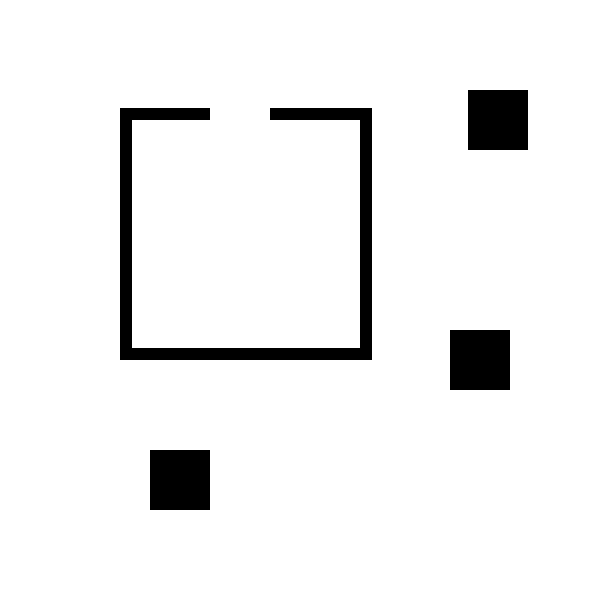

In [11]:
# We visualize the scene below.
include("../inverse-planning/viz.jl")
visualize() do
    draw_scene(scene)
end

Next, we load a file that defines a `Path` data type (a sequence of
`Point`s), and a `plan_path` method, which  uses a path planning algorithm
based on rapidly exploring random tree (RRT, [1]) to find a sequence of
`Point`s beginning with `start` and ending in `dest` such that the line
segment between each consecutive pair of points does not intersect any
obstacles in the scene. The planning algorithm may fail to find a valid path,
in which case it will return a value of type `Nothing`.

`path::Union{Path,Nothing} = plan_path(start::Point, dest::Point,
scene::Scene, planner_params::PlannerParams)`

[1] [_Rapidly-exploring random trees: A new tool for path planning._](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.35.1853&rep=rep1&type=pdf)
S. M. LaValle. TR 98-11, Computer Science Dept., Iowa State University, October 1998.

In [12]:
include("../inverse-planning/planning.jl");

Let's use `plan_path` to plan a path from the lower-left corner of the scene
into the interior of the box.

In [20]:
start = Point(0.1, 0.1)
dest = Point(0.5, 0.5)
planner_params = PlannerParams(rrt_iters=600, rrt_dt=3.0,
                               refine_iters=3500, refine_std=1.)
example_path = plan_path(start, dest, scene, planner_params)

Path(Point[Point(0.1, 0.1), Point(0.3875674338507151, 0.054621843431089154), Point(0.414287580870771, 0.05639328844991309), Point(0.7587386392965756, 0.22835704944042326), Point(0.6879249703243229, 0.8458755977727632), Point(0.6686762563766231, 0.9086587078545951), Point(0.6138015687488229, 0.9659195614031177), Point(0.5164740969922237, 0.8896817098947548), Point(0.48816494868566407, 0.877938839495345), Point(0.45224079595748745, 0.8745133011303703), Point(0.4299541425490161, 0.6605627188302156), Point(0.5, 0.5)])

We visualize the path below with the function `visualize` (defined in the
external file we loaded), which will visualize the path in the scene.
The start location is shown as a blue circle, the
destination as a red rhombus, and the path in orange. Run the cell above followed by
the cell below a few times to see the variability in the paths generated by
`plan_path` for these inputs.

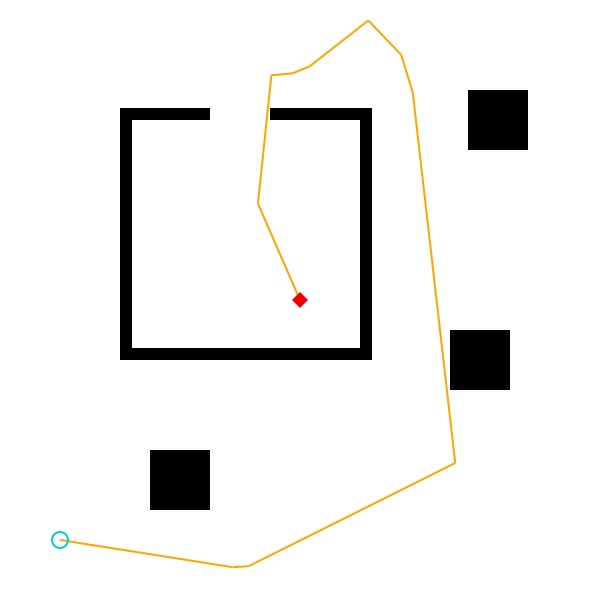

In [21]:
visualize() do
    draw_trace(Dict(:start => start,
                    :dest => dest,
                    :scene => scene,
                    :path => example_path.points);
               should_draw_measurements=false)
end

We also need a model for how the agent moves along its path.
We will assume that the agent moves along its path a constant speed. The file
loaded above also defines a method `walk_path(path, speed, dt, num_ticks)` 
that computes the locations of the agent at a set of timepoints 
(a vector of `Point`s sampled at time intervals of `dt` starting at time `0.`),
given the path and the speed of the agent:

In [22]:
speed = 1.
dt = 0.1
num_ticks = 10;
example_locations = walk_path(example_path, speed, dt, num_ticks)
println(example_locations)

Point[Point(0.1, 0.1), Point(0.19877773691184686, 0.08441286778865442), Point(0.2975554738236937, 0.06882573557730884), Point(0.3964222393959563, 0.05520888365822557), Point(0.48773828955802656, 0.09306282336440519), Point(0.5772081894524517, 0.13772977997532204), Point(0.666678089346877, 0.18239673658623895), Point(0.7561479892413021, 0.22706369319715577), Point(0.7476757320463816, 0.3248292492942668), Point(0.7362829402572182, 0.4241781511263895)]


Now, we are prepated to write our generative model for the motion of the agent.

In [23]:
@gen function agent_model(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams)

    # sample the start point of the agent from the prior
    start_x ~ uniform(0, 1)
    start_y ~ uniform(0, 1)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    dest_x ~ uniform(0, 1)
    dest_y ~ uniform(0, 1)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path === nothing
    
    # sample the speed from the prior
    speed ~ uniform(0.3, 1)

    if planning_failed   
        # path planning failed; assume agent stays at start location indefinitely
        locations = fill(start, num_ticks)
    else   
        # path planning succeeded; move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.01
    for (i, point) in enumerate(locations)
        x = {:meas => (i, :x)} ~ normal(point.x, noise)
        y = {:meas => (i, :y)} ~ normal(point.y, noise)
    end

    return (planning_failed, maybe_path)
end;

We can now perform a traced execution of `agent_model` and examine the
random choices it made:

### Exercise

Using `simulate` (or `generate`, without any constraints) to sample a trace,
get the random choices made by this model. Parameterize the planner using
`PlannerParams` with the same parameters as above.

In [87]:
trace = Gen.simulate(agent_model, (scene, dt, num_ticks, planner_params))
choices = Gen.get_choices(trace)
display(choices)

│
├── :start_x : 0.7506220925454876
│
├── :dest_y : 0.013167258142074978
│
├── :start_y : 0.34423284427434486
│
├── :dest_x : 0.04138486256317586
│
├── :speed : 0.7567120960686875
│
└── :meas
    │
    ├── (3, :x) : 0.6187369628117949
    │
    ├── (4, :y) : 0.2502039312343604
    │
    ├── (7, :x) : 0.3348934138565467
    │
    ├── (2, :y) : 0.3005084472717531
    │
    ├── (10, :y) : 0.031339905238403104
    │
    ├── (5, :y) : 0.21503722651049414
    │
    ├── (4, :x) : 0.5569255663310101
    │
    ├── (2, :x) : 0.673895636670495
    │
    ├── (10, :x) : 0.12956254235236858
    │
    ├── (8, :y) : 0.13675635763423716
    │
    ├── (1, :y) : 0.3689031953169478
    │
    ├── (5, :x) : 0.49013746378050904
    │
    ├── (6, :y) : 0.19262266252140434
    │
    ├── (9, :y) : 0.07495832999302598
    │
    ├── (8, :x) : 0.2931354954372282
    │
    ├── (3, :y) : 0.27894143971036045
    │
    ├── (1, :x) : 0.7310591880826344
    │
    ├── (6, :x) : 0.3945047919580033
    │
    ├── (7, :y) : 

<!-- # BEGIN ANSWER KEY 2A.1

planner_params = PlannerParams(rrt_iters=600, rrt_dt=3.0,
                               refine_iters=3500, refine_std=1.)
trace = Gen.simulate(agent_model, (scene, dt, num_ticks, planner_params));
choices = Gen.get_choices(trace)
display(choices)

# END ANSWER KEY -->
<hr>

Next we explore the assumptions of the model by sampling many traces from the
generative function and visualizing them. We have created a visualization
specialized for this generative function in the file we included above.
It also defined a `visualize_grid` method to plot traces in a grid.

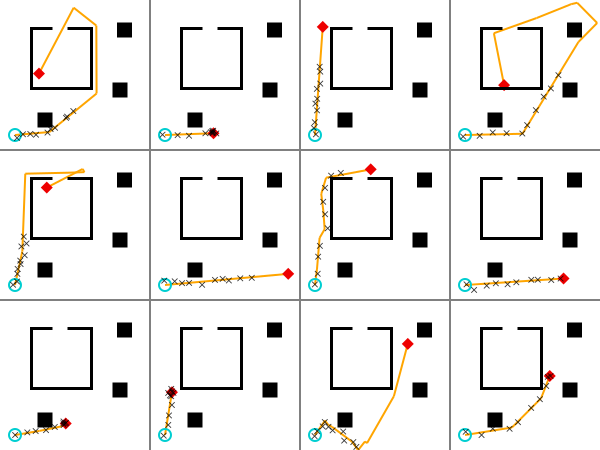

In [27]:
# Let's visualize several traces of the function, with the start location fixed to
# a point in the lower-left corner:
constraints = Gen.choicemap()
constraints[:start_x] = 0.1
constraints[:start_y] = 0.1

traces = [Gen.generate(
    agent_model, (scene, dt, num_ticks, planner_params), constraints
    )[1] for i in 1:12];
visualize_grid(traces, 4, 600; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true, markersize=6)
end

In this visualization, the measured coordinates at each
time point are represented by black $\times$ marks. The path, if path planning was
succesful, is shown as an orange line from the start point to the destination
point. Notice that the speed of the agent is different in each case. Also note that
the we observe the agent for a fixed amount of time, in which they may or may not
finish walking their planned path.

<hr>

### Exercise

Edit the constraints passed to the inference algorithm:

1. Constrain the start of the agent to be at $x = 0.9$, $y = 0.1$.
2. Constrain the destination of the agent to be at $x = 0.9$, $y = 0.8$.


Visualize the resulting prior. We have provided some starter code.

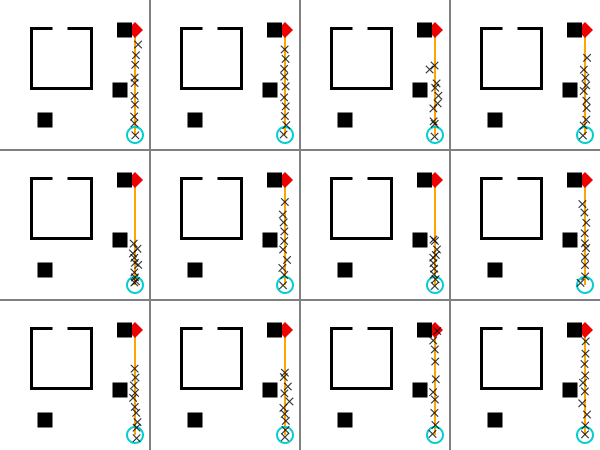

In [30]:
# < put your code here>
constraints = Gen.choicemap()
constraints[:start_x] = 0.9
constraints[:start_y] = 0.1
constraints[:dest_x] = 0.9
constraints[:dest_y] = 0.8

traces_constrained = []
for i in 1:12
    # Modify the following line:
    (trace_constrained, _) = Gen.generate(agent_model, (scene, dt, num_ticks, planner_params), constraints)
    push!(traces_constrained, trace_constrained)
end

# Visualize:
visualize_grid(traces_constrained, 4, 600; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true)
end

<!-- # BEGIN ANSWER KEY 2A.2

constraints = Gen.choicemap()
constraints[:start_x] = 0.9
constraints[:start_y] = 0.1

constraints[:dest_x] = 0.9
constraints[:dest_y] = 0.8

traces_constrained = []
for i in 1:12
    # Modify the following line:
    (trace_constrained, _) = Gen.generate(agent_model, (scene, dt, num_ticks, planner_params), constraints)
    push!(traces_constrained, trace_constrained)
end

# Visualize:
visualize_grid(traces_constrained, 4, 600; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true)
end

# END ANSWER KEY -->
<hr>

### Exercise
The `rrt_iters` field of `PlannerParams` is the number of iterations of the RRT
algorithm to use. The `refine_iters` field of `PlannerParams` is the number of
iterations of path refinement. These parameters affect the distribution on
paths of the agent. Visualize traces of the `agent_model` with a couple of
different settings of these two parameters to the path planning algorithm for
fixed starting point and destination point. Try setting them to smaller
values. Discuss.

We have provided starter code.

In [31]:
constraints = Gen.choicemap()
constraints[:start_x] = 0.1
constraints[:start_y] = 0.1;

Modify the `PlannerParams` in the cell below.

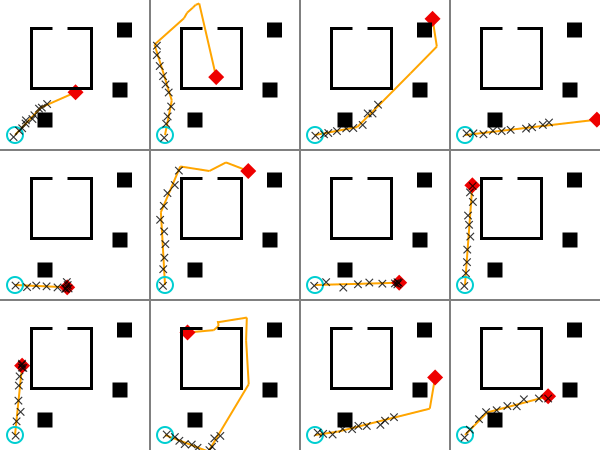

In [41]:
planner_params = PlannerParams(
    rrt_iters=300, rrt_dt=3.0, refine_iters=2000, refine_std=1.) # < change this line>

#smaller rrt_iters = might not reach destination 
#smaller refine_iters = might have a pretty inefficient path

traces = [Gen.generate(agent_model, (scene, dt, num_ticks, planner_params), constraints)[1] for i in 1:12];
visualize_grid(traces, 4, 600; separators="gray") do trace, frame 
    draw_trace(trace, frame; draw_measurements=true)
end

<hr>

For the next few sections of the notebook, let's reset any variables that may have changed during your exploration with the model.

In [42]:
start = Point(0.1, 0.1)
dt = 0.1
num_ticks = 10
planner_params = PlannerParams(rrt_iters=600, rrt_dt=3.0,
                               refine_iters=3500, refine_std=1.);

We will infer the destination of the agent for the given sequence of observed locations:

In [43]:
measurements = [
    Point(0.0980245, 0.104775),
    Point(0.113734, 0.150773),
    Point(0.100412, 0.195499),
    Point(0.114794, 0.237386),
    Point(0.0957668, 0.277711),
    Point(0.140181, 0.31304),
    Point(0.124384, 0.356242),
    Point(0.122272, 0.414463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

<hr>

### Exercise

Run inference using Gen's built-in importance resampling implementation. Use
50 importance samples (`amt_computation`). 

To see how to use the built-in importance resampling function, run
```?Gen.importance_resampling``` or check out the
[documentation](https://www.gen.dev/docs/dev/ref/importance/#Gen.importance_resampling).

In [44]:
?Gen.importance_resampling

```
(trace, lml_est) = importance_resampling(model::GenerativeFunction,
    model_args::Tuple, observations::ChoiceMap, num_samples::Int;
    verbose=false)

(traces, lml_est) = importance_resampling(model::GenerativeFunction,
    model_args::Tuple, observations::ChoiceMap,
    proposal::GenerativeFunction, proposal_args::Tuple,
    num_samples::Int; verbose=false)
```

Run sampling importance resampling, returning a single trace.

Unlike `importance_sampling`, the memory used constant in the number of samples.

Setting `verbose=true` prints a progress message every sample.


We have provided some starter code.

In [45]:
function do_inference(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams, 
        start::Point, measurements::Vector{Point}, amount_of_computation::Int)
    
    # Constrain the observed measurements.
    observations = Gen.choicemap()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end
    
    # < put your code here>

    (trace, lml_est) = importance_resampling(agent_model,
    (scene, dt, num_ticks, planner_params), observations, 50;
    verbose=false)
    
    return trace
end;

<!-- # BEGIN ANSWER KEY 2A.3

function do_inference(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams, 
        start::Point, measurements::Vector{Point}, amount_of_computation::Int)
    
    # Constrain the observed measurements.
    observations = Gen.choicemap()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(
        agent_model, (scene, dt, num_ticks, planner_params),
        observations, amount_of_computation)
    
    return trace
end;

# END ANSWER KEY -->
#### Visualize your answer
Below, we run this algorithm 500 times, to generate 500 approximate samples
from the posterior distribution on the destination. The inferred destinations
should appear as red rhombuses on the map. The following function
visualizes the paths overlaid on the scene.

In [46]:
function visualize_inference(measurements, scene, start; computation_amt=50, samples=1000)
    visualize() do
        for i in 1:samples
            trace = do_inference(scene, dt, num_ticks, planner_params, start, measurements, computation_amt)
            draw_trace(trace; draw_measurements=true, draw_path=false)
        end
    end
end;


And now we run it! Note that this might take a while.

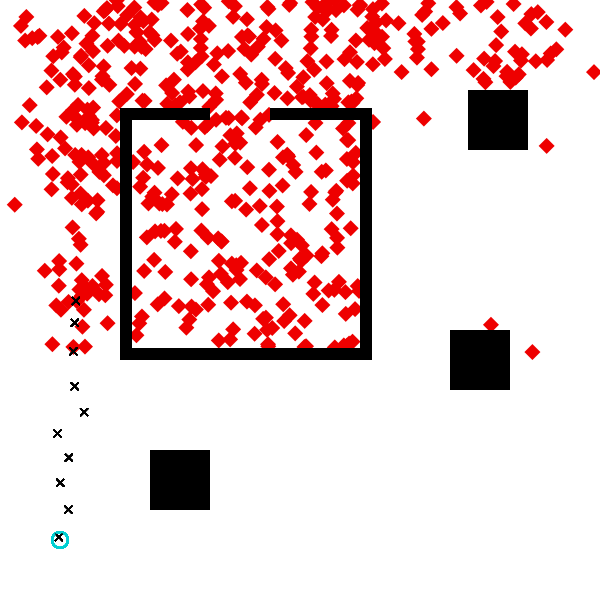

In [47]:
visualize_inference(
    measurements, scene, start, computation_amt=100, samples=500)



####how is this actually data-driven??? Seems just like importance sampling with constraints?

The algorithm has made reasonable inferences about where the agent was likely
trying to go.

Note that the above illustration takes a while to produce. This is
because computing each endpoint requires sampling 100 times from the default proposal (which
runs the RRT planner). When our models contain more expensive components, like
the path-planner, the computational demands of inference increase accordingly.
This motivates us to find more efficient inference algorithms, that will
require fewer model evaluations to produce good results.

<hr>

### Exercise

In this problem, you'll explore the effect of changing the _scene_ on the
inferences we make about the agent. Below, we've reproduced the code for
constructing the scene in which we performed inference above. Modify the scene
so that there is an opening into the "room" along the _bottom_ wall, in
addition to the already-existing door along top wall. Otherwise, the scene
should be identical to the one above.

Rerun inference. The results should be qualitatively different from the
results generated above, even though the observed movements of the agent are
identical. **Write a one- or two-sentence description of how the results are
different, and why.** Please address:

1. Why would a _human_ make different inferences about the agent's likely
   destination in the two different scenes?
2. To what extent does the _model_ succeed in producing qualitiatively
   different results in the two scenes? Why? (Concretely, why are certain
   proposals more often rejected by importance sampling in the two-door scene
   than in the one-door scene?)

In [48]:
scene_2doors = Scene(xmin=0, xmax=1, ymin=0, ymax=1)

# Add the three blocks.
add_obstacle!(scene_2doors, make_square(Point(0.30, 0.20), 0.1))
add_obstacle!(scene_2doors, make_square(Point(0.83, 0.80), 0.1))
add_obstacle!(scene_2doors, make_square(Point(0.80, 0.40), 0.1))

# Add the walls. You will need to change this code. In particular, you will need to edit 
# one of these lines (the one that constructs the bottom wall of the room) and add one new line
# (because in order to create the "door", you will actually need to represent the bottom wall
# as two separate rectangular obstacles -- as the sample code already does for the top wall).
horizontal = false
vertical = true
wall_thickness = 0.02
#add_obstacle!(scene_2doors, make_line(horizontal, Point(0.20, 0.40), 0.40, wall_thickness)) #bottom line
add_obstacle!(scene_2doors, make_line(horizontal, Point(0.60 - 0.15, 0.40), 0.15 + wall_thickness, wall_thickness)) #top right boundary
add_obstacle!(scene_2doors, make_line(horizontal, Point(0.20, 0.40), 0.15, wall_thickness)) #top left boundary
add_obstacle!(scene_2doors, make_line(vertical, Point(0.60, 0.40), 0.40, wall_thickness)) #right line
add_obstacle!(scene_2doors, make_line(horizontal, Point(0.60 - 0.15, 0.80), 0.15 + wall_thickness, wall_thickness)) #top right boundary
add_obstacle!(scene_2doors, make_line(horizontal, Point(0.20, 0.80), 0.15, wall_thickness)) #top left boundary
add_obstacle!(scene_2doors, make_line(vertical, Point(0.20, 0.40), 0.40, wall_thickness)); #left line

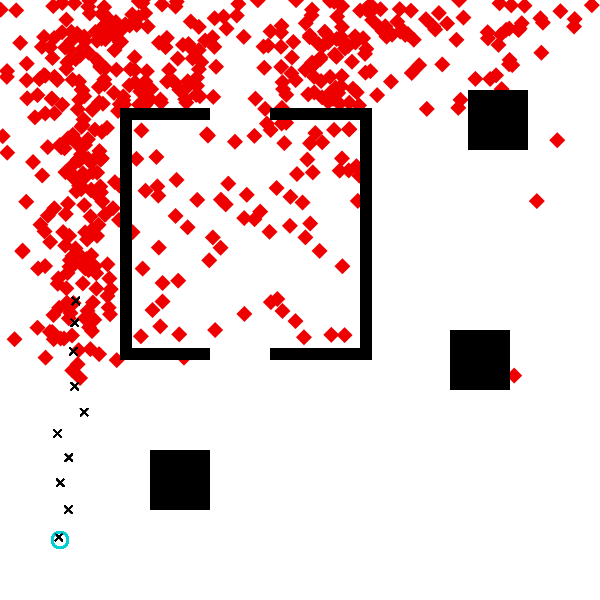

In [49]:
# Perform and visualize inference:
visualize_inference(measurements, scene_2doors, start, computation_amt=100, samples=500)

#much less likely to be inside the box, as otherwise you would have made a right turn logically and headed for the bottom entrance

**Free response:** What changed about the inferences when you changed the scene,
and why? You might address:

1. Why would a _human_ make different inferences about the agent's likely
   destination in the two different scenes?
2. To what extent does the _model_ succeed in producing qualitiatively
   different results in the two scenes? (Concretely, why are certain proposals
   more often rejected by importance sampling in the two-door scene than in
   the one-door scene?)

<hr>
<!-- # BEGIN ANSWER KEY 2.4

scene_2doors = Scene(xmin=0, xmax=1, ymin=0, ymax=1)

# Add the three blocks.
add_obstacle!(scene_2doors, make_square(Point(0.30, 0.20), 0.1))
add_obstacle!(scene_2doors, make_square(Point(0.83, 0.80), 0.1))
add_obstacle!(scene_2doors, make_square(Point(0.80, 0.40), 0.1))

horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene_2doors, make_line(horizontal, Point(0.60 - 0.15, 0.40), 0.15 + wall_thickness, wall_thickness))
add_obstacle!(scene_2doors, make_line(horizontal, Point(0.20, 0.40), 0.15, wall_thickness))
add_obstacle!(scene_2doors, make_line(vertical, Point(0.60, 0.40), 0.40, wall_thickness))
add_obstacle!(scene_2doors, make_line(horizontal, Point(0.60 - 0.15, 0.80), 0.15 + wall_thickness, wall_thickness))
add_obstacle!(scene_2doors, make_line(horizontal, Point(0.20, 0.80), 0.15, wall_thickness))
add_obstacle!(scene_2doors, make_line(vertical, Point(0.20, 0.40), 0.40, wall_thickness))

# Perform and visualize inference:
visualize_inference(measurements, scene_2doors, start, computation_amt=50, samples=100)

# END ANSWER KEY -->

## 2. Writing a data-driven proposal as a generative function <a name="custom-proposal"></a>

The inference algorithm above used a variant of
[`Gen.importance_resampling`](https://probcomp.github.io/Gen/dev/ref/importance/#Gen.importance_resampling)
that does not take a custom proposal distribution. It uses the default
proposal distribution associated with the generative model. For generative
functions defined using the built-in modeling DSL, the default proposal
distribution is based on *ancestral sampling*, which involves sampling
unconstrained random choices from the distributions specified in the
generative model. Put more simply, each "guess" the inference algorithm
makes about the possible destination of the agent is totally uninformed
by the observed measurements; it is sampled using the prior generative
model's `dest_x` and `dest_y` sampling statements.

In [50]:
#quite important to understand - that resampling doesn't use the constraints to sample the destination!?

We can visualize this default proposal distribution by sampling from it, 
using `Gen.generate` (note, we also could use `Gen.simulate` for the same purpose, since we are not passing any constraints). The cell below shows samples of the agent's destination 
drawn from this distribution.

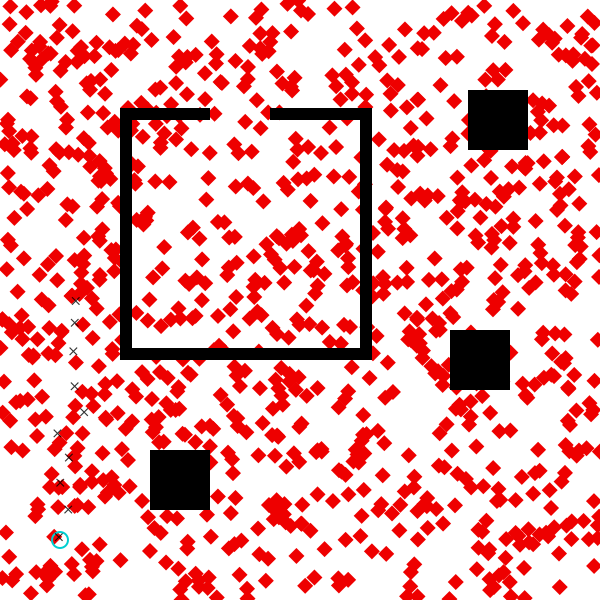

In [51]:
include("../inverse-planning/viz.jl");

traces = [Gen.generate(agent_model, (scene, dt, num_ticks, planner_params))[1] for i in 1:1000]
visualize() do

    for i in 1:1000
        trace, = Gen.generate(agent_model, (scene, dt, num_ticks, planner_params))
        draw_dest(scene, Point(trace[:dest_x], trace[:dest_y]))
    end

    draw_scene(scene)
    draw_start(scene, start)
    draw_measurements(scene, measurements)
end

Intuitively, if we see the data set above (where blue is the starting
location, and the measurements are in black), we might guess that the 
agent is more likely to be heading into the upper part of the scene. This 
is because we don't expect the agent to unecessarily backtrack on its route
to its destnation. A simple heuristic for biasing the proposal distribution 
of the destination using just the first measurement and the last measurement might be:

- If the x-coordinate of the last measurement is greater than the
  x-coordinate of the first measurement, we think the agent is probably
  headed generally to the right. Make values `:dest_x` that are greater than
  the x-coordinate of the last measurement more probable.

- If the x-coordinate of the last measurment is less than the x-coordinate of
  the first measurement, we think the agent is probably headed generally to
  the left. Make values  `:dest_x` that are smaller than the x-coordinate of
  the last measurement more probable.

We can apply the same heuristic separately for the y-coordinate.

To implement this idea, we discretize the x-axis and y-axis of the scene into
bins:

In [52]:
num_x_bins = 5
num_y_bins = 5;

We will propose the x-coordinate of the destination from a
[piecewise_uniform](https://www.gen.dev/docs/dev/ref/distributions/#Gen.piecewise_uniform)
distribution, where we set higher probability for certain bins based on the
heuristic described above and use a uniform continuous distribution for the
coordinate within a bin. The `compute_bin_probs` function below computes the
probability for each bin. The bounds of the scene are given by `min` and
`max`. The coordinates of the first and last measured points respectively are
given by `first` and `last`. We compute the probability by assigning a
"score" to each bin based on the heuristic above --- if the bin should
receive lower probability, it gets a score of 1., and if it should receive
higher probability, it gets a bin of `score_high`, where `score_high` is some
value greater than 1.

In [53]:
function compute_bin_prob(first::Float64, last::Float64, bin::Int, last_bin::Int, score_high)
    last >= first && bin >= last_bin && return score_high
    last < first && bin <= last_bin && return score_high
    return 1.
end

function compute_bin_probs(num_bins::Int, min::Float64, max::Float64, first::Float64, last::Float64, score_high)
    bin_len = (max - min) / num_bins
    last_bin = Int(floor(last / bin_len)) + 1
    probs = [compute_bin_prob(first, last, bin, last_bin, score_high) for bin=1:num_bins]
    total = sum(probs)
    return [p / total for p in probs]
end;

We will see how to automatically tune the value of `score_high` shortly. For
now, we will use a value of 5. Below, we see that for the data set of
measurements, shown above the probabilities of higher bins are indeed 5x
larger than those of lower bins, becuase the agent seems to be headed up.

In [54]:
compute_bin_probs(num_y_bins, scene.ymin, scene.ymax, measurements[1].y, measurements[end].y, 5.)

5-element Vector{Float64}:
 0.058823529411764705
 0.058823529411764705
 0.29411764705882354
 0.29411764705882354
 0.29411764705882354

Next, we write a generative function that applies this heuristic for both the
x-coordinate and y-coordinate, and samples the destination coordinates at
addresses `:dest_x` and `:dest_y`.

In [55]:
@gen function custom_dest_proposal(measurements::Vector{Point}, scene::Scene)

    score_high = 5.
    
    x_first = measurements[1].x
    x_last = measurements[end].x
    y_first = measurements[1].y
    y_last = measurements[end].y
    
    # sample dest_x
    x_probs = compute_bin_probs(num_x_bins, scene.xmin, scene.xmax, x_first, x_last, score_high)
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    dest_x ~ piecewise_uniform(x_bounds, x_probs)
    
    # sample dest_y
    y_probs = compute_bin_probs(num_y_bins, scene.ymin, scene.ymax, y_first, y_last, score_high)
    y_bounds = collect(range(scene.ymin, stop=scene.ymax, length=num_y_bins+1))
    dest_y ~ piecewise_uniform(y_bounds, y_probs)
    
    return nothing
end;

We can propose values of random choices from the proposal function using
[`Gen.propose`](https://probcomp.github.io/Gen/dev/ref/gfi/#Gen.propose).
This method returns the choices, as well as some other information, which we
won't need for our purposes. For now, you can think of `Gen.propose` as
similar to `Gen.generate` except that it does not produce a full execution
trace (only the choices), and it does not accept constraints. We can see the
random choices for one run of the proposal on our data set:

In [56]:
(proposed_choices, _, _) = Gen.propose(custom_dest_proposal, (measurements, scene))
proposed_choices

│
├── :dest_y : 0.42908794002288353
│
└── :dest_x : 0.8254766743535635


The function below runs the proposal 1000 times. For each run, it generates a
trace of the model where the `:dest_x` and `:dest_y` choices are constrained
to the proposed values, and then visualizes the resulting traces. We make the
proposal a parameter of the function because we will be visualizing the
output distribution of various proposals later in the notebook.

In [57]:
function visualize_custom_destination_proposal(measurements, start, dest_proposal; num_samples=100)
    visualize() do 
        for i=1:num_samples
            (proposed_choices, _) = Gen.propose(dest_proposal, (measurements, scene))
            constraints = choicemap(proposed_choices)
            constraints[:start_x] = start.x
            constraints[:start_y] = start.y
            (trace, _) = Gen.generate(agent_model, (scene, dt, num_ticks, planner_params), constraints)
            draw_dest(scene, Point(trace[:dest_x], trace[:dest_y]))
        end
        draw_scene(scene)
        draw_start(scene, start)
        draw_measurements(scene, measurements)
    end
end;

Let's visualize the output distribution of `custom_dest_proposal` for our
data set:

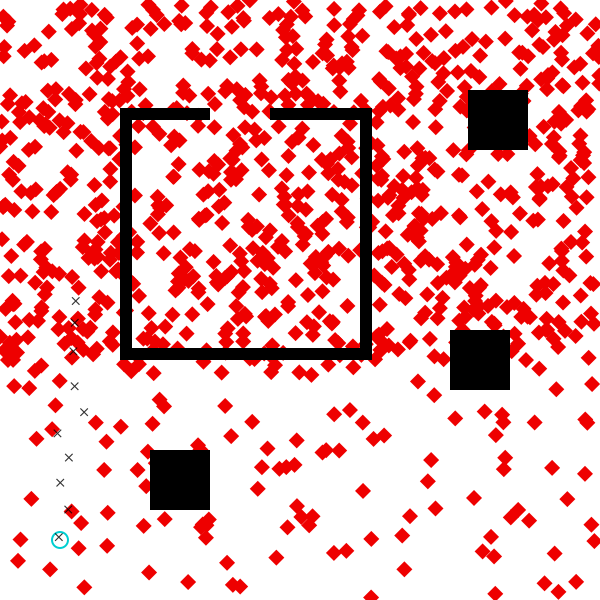

In [59]:
visualize_custom_destination_proposal(measurements, start, custom_dest_proposal, num_samples=1000)

We see that the proposal distribution indeed samples destinations in the top
half of the scene with higher probability than destinations in the bottom
half.

Alone, this is just a heuristic. But we can use it as a proposal for importance sampling, turning it into an asymptotically valid Bayesian inference algorithm. Alternatively, we can view it as a tool for speeding up our naive importance sampler, by focusing computation on regions of the space that are more likely.

## 3. Using a data-driven proposal within importance sampling <a name="using"></a>

We now use our data-driven proposal within an inference algorithm. There is a
second variant of
[`Gen.importance_resampling`](https://probcomp.github.io/Gen/dev/ref/importance/#Gen.importance_resampling)
that accepts a generative function representing a custom proposal. This
proposal generative function makes traced random choices at the addresses of
a subset of the unobserved random choices made by the generative model. In
our case, these addresses are `:dest_x` and `:dest_y`.

<hr>

### Exercise

Implement an inference program that uses this second variant of importance resampling. 


Because we will experiment with different data-driven proposals, we make the
proposal into an agument of our inference program. We assume that the
proposal accepts arguments `(measurements, scene)`.

This time, use only 5 importance samples (`amt_computation`). You can run
`?Gen.importance_resampling` or check out the
[documentation](https://probcomp.github.io/Gen/dev/ref/inference/#Importance-Sampling-1)
to understand how to supply the arguments to invoke this second version of of
importance resampling.

In [60]:
?Gen.importance_resampling

```
(trace, lml_est) = importance_resampling(model::GenerativeFunction,
    model_args::Tuple, observations::ChoiceMap, num_samples::Int;
    verbose=false)

(traces, lml_est) = importance_resampling(model::GenerativeFunction,
    model_args::Tuple, observations::ChoiceMap,
    proposal::GenerativeFunction, proposal_args::Tuple,
    num_samples::Int; verbose=false)
```

Run sampling importance resampling, returning a single trace.

Unlike `importance_sampling`, the memory used constant in the number of samples.

Setting `verbose=true` prints a progress message every sample.


We have provided some starter code.

In [65]:
function do_inference_data_driven(
        dest_proposal::GenerativeFunction,
        scene::Scene, dt::Float64,
        num_ticks::Int, planner_params::PlannerParams,
        start::Point, measurements::Vector{Point}, 
        amount_of_computation::Int)
    
    observations = Gen.choicemap((:start_x, start.x), (:start_y, start.y))
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end
    
    # trace = ... < put your code here>

    (trace, lml_est) = importance_resampling(agent_model,
    (scene, dt, num_ticks, planner_params), observations,
    dest_proposal, (measurements, scene),
    5; verbose=false)
    
    return trace
end;

function visualize_data_driven_inference(measurements, scene, start, proposal; amt_computation=50, samples=1000)
    visualize() do 
      for i=1:samples
          trace = do_inference_data_driven(proposal, 
              scene, dt, num_ticks, planner_params, start, measurements, amt_computation)
          draw_dest(scene, Point(trace[:dest_x], trace[:dest_y]))
      end
        draw_scene(scene)
        draw_start(scene, start)
        draw_measurements(scene, measurements)
    end
end;

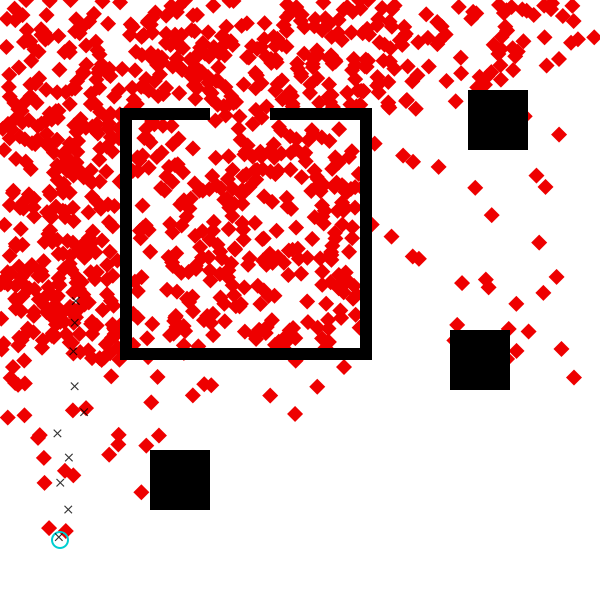

In [66]:
visualize_data_driven_inference(measurements, scene, start, custom_dest_proposal; amt_computation=5, samples=1000)

The code executes much more quickly than before, because we are only taking five proposal samples to generate each.

We compare this to the original algorithm that used the default proposal, for
the same "amount of computation" of 5.

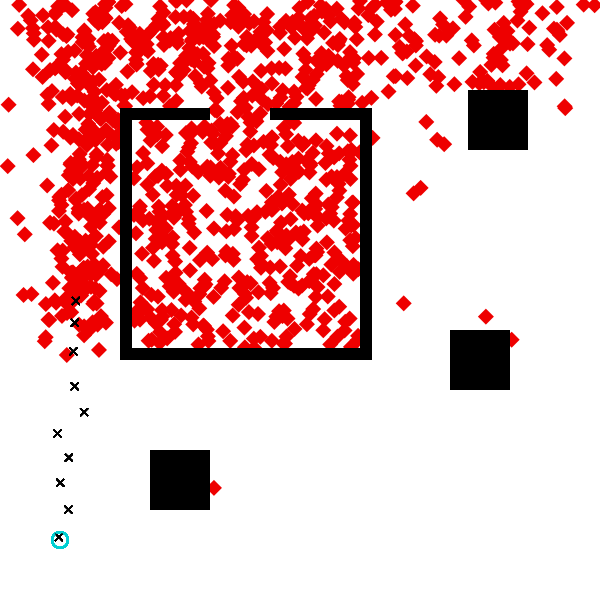

In [68]:
visualize_inference(measurements, scene, start, computation_amt=5, samples=1000)



#why are they the same??????? #???

We should see that the results are somewhat more accurate using the
data-driven proposal.  In particular, there is less probability mass in the
lower left corner when using the data-driven proposal.

<hr>

<!-- # BEGIN ANSWER KEY 2A.5

function do_inference_data_driven(
        dest_proposal::GenerativeFunction,
        scene::Scene, dt::Float64,
        num_ticks::Int, planner_params::PlannerParams,
        start::Point, measurements::Vector{Point}, 
        amount_of_computation::Int)
    
    observations = Gen.choicemap((:start_x, start.x), (:start_y, start.y))
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end
    
    # invoke the variant of importance_resampling 
    # that accepts a custom proposal (dest_proposal).
    # the arguments to the custom proposal are (measurements, scene)
    (trace, _) = Gen.importance_resampling(agent_model, (scene, dt, num_ticks, planner_params), observations, 
        dest_proposal, (measurements, scene), amount_of_computation)
    
    return trace
end;

function visualize_data_driven_inference(measurements, scene, start, proposal; amt_computation=50, samples=1000)
    visualize() do 
      for i=1:samples
          trace = do_inference_data_driven(proposal, 
              scene, dt, num_ticks, planner_params, start, measurements, amt_computation)
          draw_dest(scene, Point(trace[:dest_x], trace[:dest_y]))
      end
        draw_scene(scene)
        draw_start(scene, start)
        draw_measurements(scene, measurements)
    end
end;

# END ANSWER KEY -->

## 4. Training the parameters of a data-driven proposal <a name="training"></a>

Our choice of the `score_high` value of 5. was somewhat arbitrary. To use
more informed value, we can make `score_high` into a [*trainable
parameter*](https://www.gen.dev/docs/dev/ref/gfi/#Trainable-parameters-1)
of the generative function. Below, we write a new version of the proposal
function that makes `score_high` trainable. However, the optimization
algorithms we will use for training work best with *unconstrained* parameters
(parameters that can take any value on the real line), but `score_high` must
be positive. Therefore, we introduce an unconstrained trainable parameter
mamed `log_score_high`, and use `exp()` to ensure that `score_high` is
positive:

In [69]:
@gen function custom_dest_proposal_trainable(measurements::Vector{Point}, scene::Scene)

    @param log_score_high::Float64
    
    x_first = measurements[1].x
    x_last = measurements[end].x
    y_first = measurements[1].y
    y_last = measurements[end].y
    
    # sample dest_x
    x_probs = compute_bin_probs(num_x_bins, scene.xmin, scene.xmax, x_first, x_last, exp(log_score_high))
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    dest_x ~ piecewise_uniform(x_bounds, x_probs)
    
    # sample dest_y
    y_probs = compute_bin_probs(num_y_bins, scene.ymin, scene.ymax, y_first, y_last, exp(log_score_high))
    y_bounds = collect(range(scene.ymin, stop=scene.ymax, length=num_y_bins+1))
    dest_y ~ piecewise_uniform(y_bounds, y_probs)
    
    return nothing
end;

We initialize the value of `score_high` to 1. For this value, our custom
proposal gives a uniform distribution, and is the same as the default
proposal.

In [74]:
Gen.init_param!(custom_dest_proposal_trainable, :log_score_high, 0.);

Let's visualize the proposed distribution prior to training to confirm that
it is a uniform distribution.

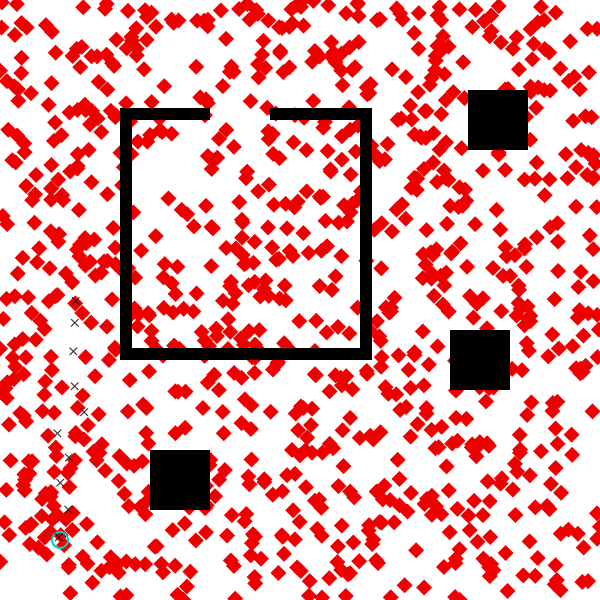

In [75]:
visualize_custom_destination_proposal(measurements, start, custom_dest_proposal_trainable, num_samples=1000)

Now, we train the generative function. First, we will require a
data-generator that generates the training data. The data-generator is a
function of no arguments that returns a tuple of the form `(inputs, constraints)`. 
The `inputs` are the arguments to the generative function
being trained, and the `constraints` contains the desired values of random
choices made by the function for those arguments. For the training
distribution, we will use the distribution induced by the generative model
(`agent_model`), restricted to cases where planning actually succeeded. When
planning failed, the agent just stays at the same location for all time, and
we won't worry about tuning our proposal for that case. The training
procedure will attempt to maximize the expected conditional log probablity
(density) that the proposal function generates the constrained values,
when run on the arguments. 
Note that this is an *average case* objective function --- the resulting proposal 
distribution may perform better on some data sets than others.

In [76]:
function data_generator()
    
    # since these names are used in the global scope, explicitly declare it
    # local to avoid overwriting the global variable
    local measurements
    local choices
    
    # obtain an execution of the model where planning succeeded
    done = false
    while !done
        (choices, _, retval) = Gen.propose(agent_model, (scene, dt, num_ticks, planner_params))
        (planning_failed, maybe_path) = retval       
        done = !planning_failed
    end

    # construct arguments to the proposal function being trained
    measurements = [Point(choices[:meas => (i, :x)], choices[:meas => (i, :y)]) for i=1:num_ticks]
    inputs = (measurements, scene)
    
    # construct constraints for the proposal function being trained
    constraints = Gen.choicemap()
    constraints[:dest_x] = choices[:dest_x]
    constraints[:dest_y] = choices[:dest_y]
    
    return (inputs, constraints)
end;

Next, we choose type of optimization algorithm we will use for training. Gen
supports a set of gradient-based optimization algorithms (see [Optimizing
Trainable
Parameters](https://www.gen.dev/docs/dev/ref/parameter_optimization/#Optimizing-Trainable-Parameters-1)).
Here we will use gradient descent with a fixed step size of 0.001.

In [77]:
update = Gen.ParamUpdate(Gen.FixedStepGradientDescent(0.001), custom_dest_proposal_trainable);

Finally, we use the
[`Gen.train!`](https://probcomp.github.io/Gen/dev/ref/inference/#Gen.train!)
method to actually do the training.

For each epoch, `Gen.train!` makes `epoch_size` calls to the data-generator
to construct a batch of training data for that epoch. Then, it iteratively
selects `num_minibatch` subsets of the epoch training data, each of size
`100`, and applies the update once per minibatch. At the end of the epoch, it
generates another batch of evaluation data (of size `evaluation_size`) which
it uses to estimate the objective function (the expected conditional log
likelihood under the data-generating distribution).

Here, we are running 200 gradient-descent updates, where each update is using
a gradient estimate obtained from 100 training examples. The method prints
the estimate of the objective function after each epoch.

In [78]:
@time scores = Gen.train!(custom_dest_proposal_trainable, data_generator, update,
    num_epoch=200, epoch_size=100, num_minibatch=1, minibatch_size=100, evaluation_size=100, verbose=true);

epoch 1: generating 100 training examples...
epoch 1: training using 1 minibatches of size 100...
epoch 1: evaluating on 100 examples...
epoch 1: est. objective value: 0.06605259976734121
epoch 2: generating 100 training examples...
epoch 2: training using 1 minibatches of size 100...
epoch 2: evaluating on 100 examples...
epoch 2: est. objective value: 0.11224786699218324
epoch 3: generating 100 training examples...
epoch 3: training using 1 minibatches of size 100...
epoch 3: evaluating on 100 examples...
epoch 3: est. objective value: 0.13553392749558765
epoch 4: generating 100 training examples...
epoch 4: training using 1 minibatches of size 100...
epoch 4: evaluating on 100 examples...
epoch 4: est. objective value: 0.1858204804257461
epoch 5: generating 100 training examples...
epoch 5: training using 1 minibatches of size 100...
epoch 5: evaluating on 100 examples...
epoch 5: est. objective value: 0.22275362105690535
epoch 6: generating 100 training examples...
epoch 6: trainin

epoch 108: evaluating on 100 examples...
epoch 108: est. objective value: 0.756297047498139
epoch 109: generating 100 training examples...
epoch 109: training using 1 minibatches of size 100...
epoch 109: evaluating on 100 examples...
epoch 109: est. objective value: 0.6148425447606995
epoch 110: generating 100 training examples...
epoch 110: training using 1 minibatches of size 100...
epoch 110: evaluating on 100 examples...
epoch 110: est. objective value: 0.6922508795641895
epoch 111: generating 100 training examples...
epoch 111: training using 1 minibatches of size 100...
epoch 111: evaluating on 100 examples...
epoch 111: est. objective value: 0.5801514822084943
epoch 112: generating 100 training examples...
epoch 112: training using 1 minibatches of size 100...
epoch 112: evaluating on 100 examples...
epoch 112: est. objective value: 0.7585505705854133
epoch 113: generating 100 training examples...
epoch 113: training using 1 minibatches of size 100...
epoch 113: evaluating on 1

epoch 161: training using 1 minibatches of size 100...
epoch 161: evaluating on 100 examples...
epoch 161: est. objective value: 0.9240893333160005
epoch 162: generating 100 training examples...
epoch 162: training using 1 minibatches of size 100...
epoch 162: evaluating on 100 examples...
epoch 162: est. objective value: 0.5130095842553246
epoch 163: generating 100 training examples...
epoch 163: training using 1 minibatches of size 100...
epoch 163: evaluating on 100 examples...
epoch 163: est. objective value: 0.775206247325026
epoch 164: generating 100 training examples...
epoch 164: training using 1 minibatches of size 100...
epoch 164: evaluating on 100 examples...
epoch 164: est. objective value: 0.7376702127774276
epoch 165: generating 100 training examples...
epoch 165: training using 1 minibatches of size 100...
epoch 165: evaluating on 100 examples...
epoch 165: est. objective value: 0.6803506641499476
epoch 166: generating 100 training examples...
epoch 166: training using 

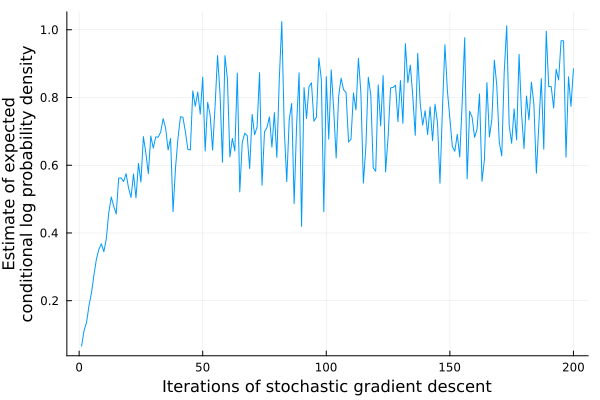

In [79]:
using Plots
plot(scores,
    xlabel="Iterations of stochastic gradient descent",
    ylabel="Estimate of expected\nconditional log probability density", 
    label=nothing)

We can read out the new value for `score_high`:

In [80]:
println(exp(Gen.get_param(custom_dest_proposal_trainable, :log_score_high)))

8.857395794167124


We see that the optimal value of the parameter is indeed larger than our
initial guess. This validates that the heuristic is indeed a useful one. We
visualize the proposal distribution below:

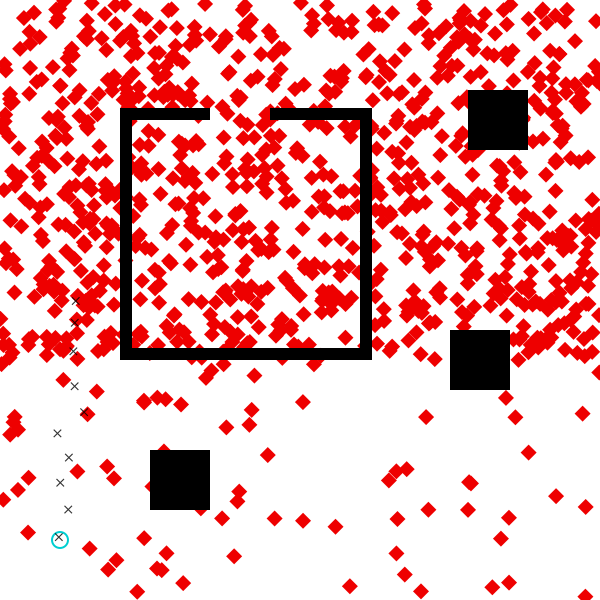

In [81]:
visualize_custom_destination_proposal(
    measurements, start, custom_dest_proposal_trainable, 
    num_samples=1000)

We can visualize the results of inference, using this newly trained proposal:

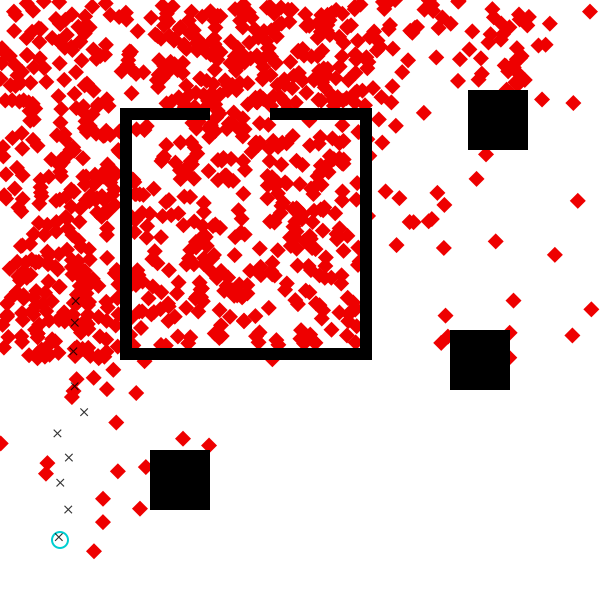

In [82]:
visualize_data_driven_inference(
    measurements, scene, start, custom_dest_proposal_trainable,
    amt_computation=5, samples=1000)

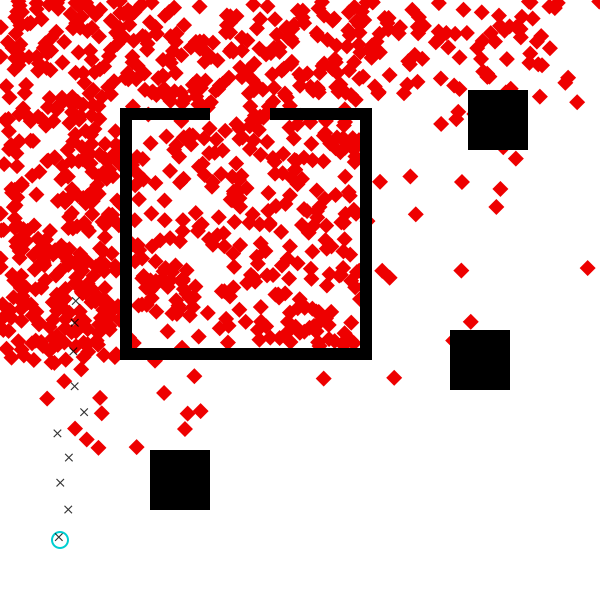

In [83]:
visualize_data_driven_inference(
    measurements, scene, start, custom_dest_proposal_trainable,
    amt_computation=10, samples=1000)

------------

### Exercise

Can you devise a data-driven proposal for the speed of the agent? If so, would you
expect it to work equally well on all data sets?

In [104]:
@gen function speed_proposal(measurements::Vector{Point}, scene::Scene)
    
    x_first = measurements[1].x
    x_last = measurements[end].x
    y_first = measurements[1].y
    y_last = measurements[end].y

    dist_travelled = sqrt((y_last - y_first)^2 + (x_last - x_first)^2)
    speed_mean = dist_travelled / dt
    speed ~ Gen.normal(speed_mean, 0.1)
    return nothing
    
end;

trace = Gen.simulate(speed_proposal, (measurements, scene))
#print(trace)

choices = Gen.get_choices(trace)
display(choices)

###don't expect it to work equally well on all datasets, because it assumes a roughly linear path from first to last observed position
## if path not linear, then agent may have travelled much more distance than estimated, so speed proposal actually too low


│
└── :speed : 3.954801789359083


<hr>

## 5. Writing and training a deep learning based data-driven proposal <a name="deep"></a>

The heuristic data-driven proposal above gave some improvement in efficiency,
but it was very simple. One way of constructing complex data-driven proposals
is to parametrize the proposal with a deep neural network or use another
class of high-capacity machine learning model (e.g. random forest). Here, we
will will write a data-driven proposal for the destination of the agent that
uses deep neural networks. In this section, we do everything manually, without
the aid of neural network libraries. We also provide an [extension to the tutorial](#) that
shows how to use PyTorch to make this process a lot easier.

In [108]:
#using a neural net to sample the destinations vs. a basic directional model

First, we define a sigmoid function for the nonlinearity in our networks.

In [105]:
nonlinearity(x) = 1.7159 * tanh.(x * 0.66666);

We will use a deep neural network with two hidden layers that takes as input
x- and y- coordinates of the first and last measurement (4 values) and
produces as output a vector of un-normalized probabilities, one for each bin
of the x-dimension. We will later sample `:dest_x` from this distribution.

In [106]:
function dest_x_neural_net(nn_params, x_first::Real, y_first::Real, x_last::Real, y_last::Real)
    (W1, b1, W2, b2, W3, b3) = nn_params
    input_layer = [x_first, y_first, x_last, y_last]
    hidden_layer_1 = nonlinearity(W1 * input_layer .+ b1)
    hidden_layer_2 = nonlinearity(W2 * hidden_layer_1 .+ b2)
    output_layer = exp.(W3 * hidden_layer_2 .+ b3)
    return output_layer
end;

After sampling the value of `:dest_x`, we will use a second deep neural
network with the same structure to sample `:dest_y`.

In [107]:
function dest_y_neural_net(nn_params, x_first::Real, y_first::Real, x_last::Real, y_last::Real)#, dest_x::Real)
    (W1, b1, W2, b2, W3, b3) = nn_params
    input_layer = [x_first, y_first, x_last, y_last]
    hidden_layer_1 = nonlinearity(W1 * input_layer .+ b1)
    hidden_layer_2 = nonlinearity(W2 * hidden_layer_1 .+ b2)
    output_layer = exp.(W3 * hidden_layer_2 .+ b3)
    return output_layer
end;

Now that we have defined our neural networks, we define our new proposal.
This generative function has a number of parameters.

In [109]:
scale_coord(coord, min, max) = (coord / (max - min)) - 0.5

@gen function custom_dest_proposal_neural(measurements::Vector{Point}, scene::Scene)
    @param x_W1::Matrix{Float64}
    @param x_b1::Vector{Float64}
    @param x_W2::Matrix{Float64}
    @param x_b2::Vector{Float64}
    @param x_W3::Matrix{Float64}
    @param x_b3::Vector{Float64}
    
    @param y_W1::Matrix{Float64}
    @param y_b1::Vector{Float64}
    @param y_W2::Matrix{Float64}
    @param y_b2::Vector{Float64}
    @param y_W3::Matrix{Float64}
    @param y_b3::Vector{Float64}
    
    num_x_bins = length(x_b3)
    num_y_bins = length(y_b3)
    
    # scale inputs to be in the range [-0.5, 0.5]
    x_first = scale_coord(measurements[1].x, scene.xmin, scene.xmax)
    x_last = scale_coord(measurements[end].x, scene.xmin, scene.xmax)
    y_first = scale_coord(measurements[1].y, scene.ymin, scene.ymax)
    y_last = scale_coord(measurements[end].y, scene.ymin, scene.ymax)
    
    # sample dest_x
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    x_probs = dest_x_neural_net((x_W1, x_b1, x_W2, x_b2, x_W3, x_b3), x_first, y_first, x_last, y_last)
    dest_x ~ piecewise_uniform(x_bounds, x_probs / sum(x_probs))
    
    # sample dest_y
    y_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_y_bins+1))
    y_probs = dest_y_neural_net((y_W1, y_b1, y_W2, y_b2, y_W3, y_b3), x_first, y_first, x_last, y_last)
    dest_y ~ Gen.piecewise_uniform(y_bounds, y_probs / sum(y_probs))
    
    return nothing
end;

We will use 50 hidden units in each of the layers of the two networks:

In [110]:
num_hidden_1 = 50
num_hidden_2 = 50;

Next, we initialize the parameters:

In [111]:
import Random
Random.seed!(3)

init_weight(shape...) = (1. / sqrt(shape[2])) * randn(shape...)

init_x_W1 = init_weight(num_hidden_1, 4)
init_x_W2 = init_weight(num_hidden_2, num_hidden_1)
init_x_W3 = init_weight(num_x_bins, num_hidden_2)

# set parameters for dest_x_neural_net predictor network
init_param!(custom_dest_proposal_neural, :x_W1, init_x_W1)
init_param!(custom_dest_proposal_neural, :x_b1, zeros(num_hidden_1))
init_param!(custom_dest_proposal_neural, :x_W2, init_x_W2)
init_param!(custom_dest_proposal_neural, :x_b2, zeros(num_hidden_2))
init_param!(custom_dest_proposal_neural, :x_W3, init_x_W3)
init_param!(custom_dest_proposal_neural, :x_b3, zeros(num_x_bins))

init_y_W1 = init_weight(num_hidden_1, 4)
init_y_W2 = init_weight(num_hidden_2, num_hidden_1)
init_y_W3 = init_weight(num_x_bins, num_hidden_2)

# set parameters for dest_y_neural_net predictor network
init_param!(custom_dest_proposal_neural, :y_W1, init_y_W1)
init_param!(custom_dest_proposal_neural, :y_b1, zeros(num_hidden_1))
init_param!(custom_dest_proposal_neural, :y_W2, init_y_W2)
init_param!(custom_dest_proposal_neural, :y_b2, zeros(num_hidden_2))
init_param!(custom_dest_proposal_neural, :y_W3, init_y_W3)
init_param!(custom_dest_proposal_neural, :y_b3, zeros(num_y_bins));

Now, we visualize the proposal distribution prior to training:

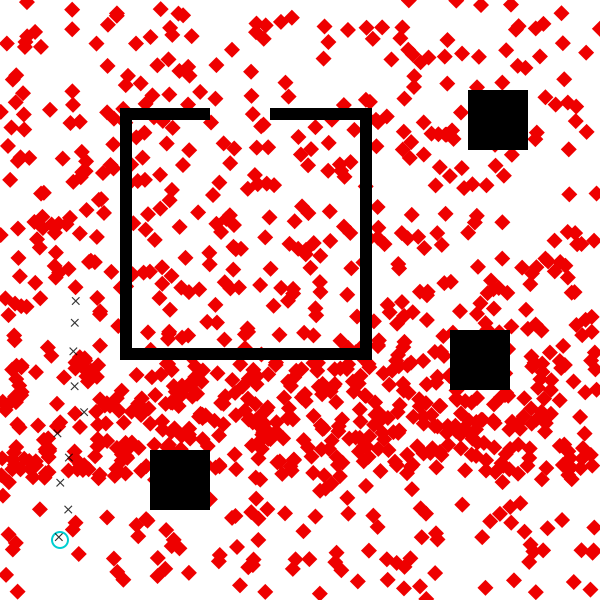

In [112]:
visualize_custom_destination_proposal(measurements, start, custom_dest_proposal_neural, num_samples=1000)

It looks like the initial distribution is roughly uniform, like the default
proposal.

Now we train the network stochastic gradient descent with a fixed step size
of 0.001 that is shared among all of the trainable parameters.

In [113]:
update = Gen.ParamUpdate(Gen.FixedStepGradientDescent(0.001), custom_dest_proposal_neural);

We use 50 epochs of training. In each epoch, we generate 100 training
examples, and we apply 100 gradient updates, where each update is based on
the gradient estimate obtained from a random set of 100 of the trainable
examples. At the end of each epoch, we estimate the objective function value
using 10000 freshly sampled examples. This process takes about 10 minutes to
run on a typical laptop CPU, so we have precomputed the results for you.

```julia
using JLD2
@time scores = Gen.train!(custom_dest_proposal_neural, data_generator, update,
    num_epoch=50, epoch_size=100, num_minibatch=100, minibatch_size=100,
    evaluation_size=1000, verbose=true);
    
let data = Dict()
    for name in [:x_W1, :x_b1, :x_W2, :x_b2, :x_W3, :x_b3, :y_W1, :y_b1, :y_W2, :y_b2, :y_W3, :y_b3]
        data[(:param, name)] = Gen.get_param(custom_dest_proposal_neural, name)
    end
    data[:scores] = scores
    save("params/custom_dest_proposal_neural_trained.jld2", "data", data)
end
```

We load the results here:

In [114]:
using JLD2
scores = let data = JLD2.load("params/custom_dest_proposal_neural_trained.jld2", "data")
    for name in [:x_W1, :x_b1, :x_W2, :x_b2, :x_W3, :x_b3, :y_W1, :y_b1, :y_W2, :y_b2, :y_W3, :y_b3]
        Gen.init_param!(custom_dest_proposal_neural, name, data[(:param, name)])
    end
    data[:scores]
end;

We plot the estimate of the objective function over epochs:

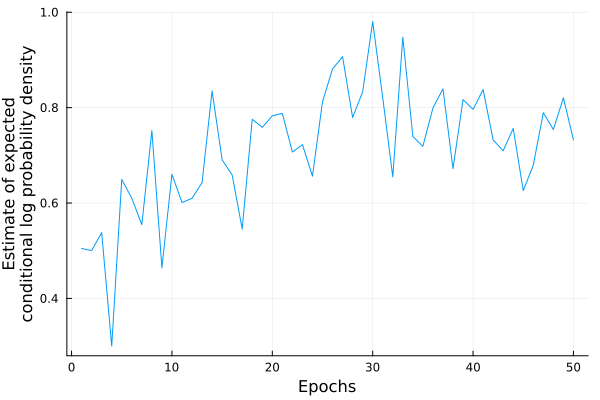

In [115]:
plot(scores,
    xlabel="Epochs", 
    ylabel="Estimate of expected\nconditional log probability density", 
    label=nothing)

Below, we visualize the trained proposal distribution for our data set:

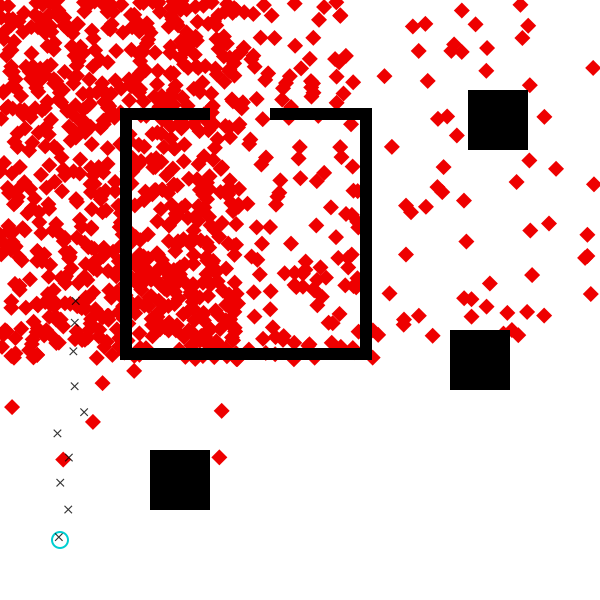

In [116]:
visualize_custom_destination_proposal(measurements, start, custom_dest_proposal_neural, num_samples=1000)

If we run inference with `amt_computation` set to 5, we see that the inferred distribution reflects the bias of the proposal:

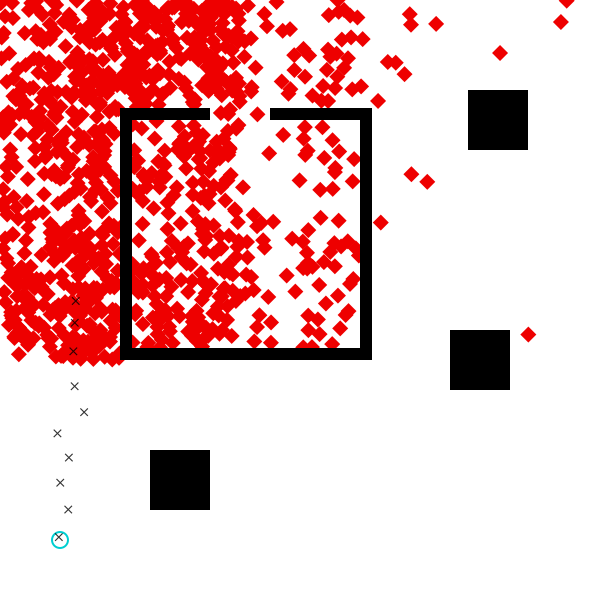

In [117]:
visualize_data_driven_inference(measurements, scene, start, custom_dest_proposal_neural,
    amt_computation=5, samples=1000)

As we increase the amount of computation, the effect of the proposal's bias
is reduced:

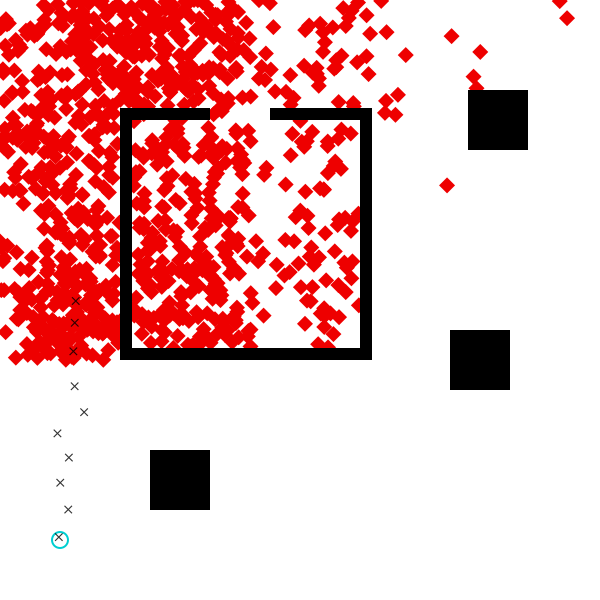

In [120]:
visualize_data_driven_inference(measurements, scene, start, custom_dest_proposal_neural,
    amt_computation=50, samples=1000)


#not reduced for me here?????

This bias-correction is more noticeable the more computation we use (though here we only draw 100 approximate posterior samples):

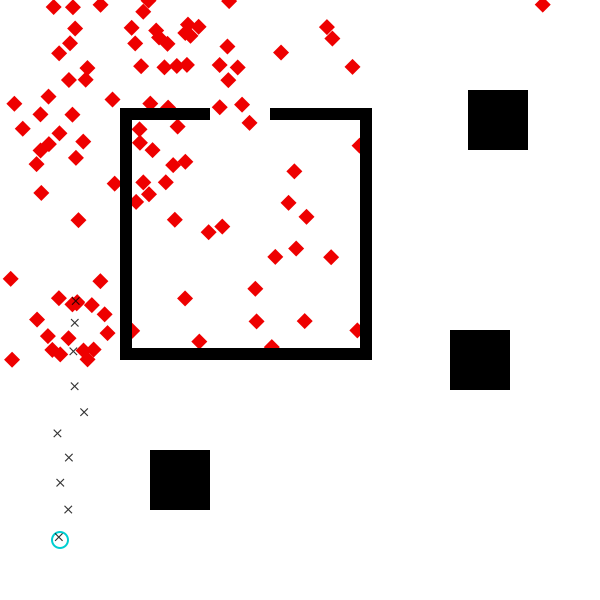

In [121]:
visualize_data_driven_inference(measurements, scene, start, custom_dest_proposal_neural,
    amt_computation=1000, samples=100)

This example highlights an important aspect of importance sampling: it not
only _upweights_ guesses that explain the data well; it also _downweights_ guesses
that are too high-probability under the proposal distribution. That is, if a proposal
is heavily biased toward one region of the state space, all guesses in that region will
be downweighted accordingly. That's why, even though (a) guesses in the left and right halves
of the room are equally likely, and (b) the
proposal stongly prefers the left half of the room, the importance sampling algorithm
samples roughly the same number of points in each half of the room.

In the limit of infinite computation, the distribution induced by importance sampling
converges to the true posterior, independent of the proposal. Indeed, using the
generic proposal with a high amount of computation produces very similar results:

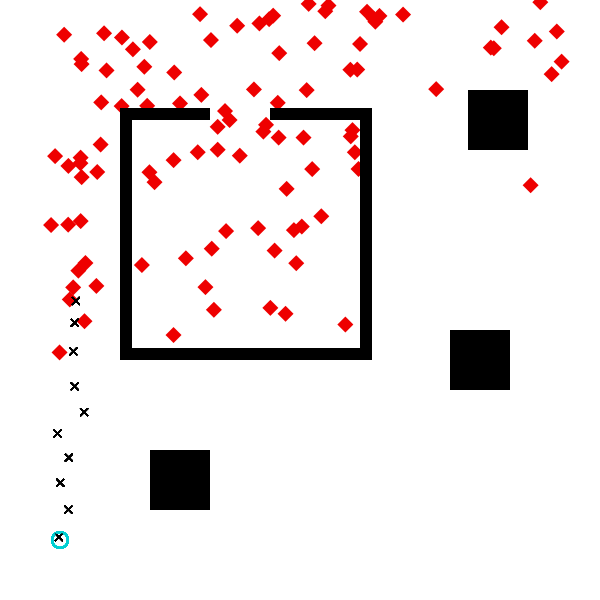

In [122]:
visualize_inference(measurements, scene, start; computation_amt=1000, samples=100)

# Pytorch Extension - Amortized Inference

In [1]:
using Pkg
Pkg.add("PyCall")
Pkg.add("Conda")

   Resolving package versions...
  No Changes to `~/Documents/9.66/gen-quickstart-master/Project.toml`
  No Changes to `~/Documents/9.66/gen-quickstart-master/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/9.66/gen-quickstart-master/Project.toml`
  No Changes to `~/Documents/9.66/gen-quickstart-master/Manifest.toml`


In [2]:
using PyCall
math = pyimport("math")
math.sin(math.pi / 4)

0.7071067811865475

In [3]:
using Conda
Conda.add("pytorch", channel="pytorch")

[ Info: Running `conda install -y -c pytorch pytorch` in root environment


Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0




In [4]:
using Gen, PyCall, GenPyTorch

In [5]:
include("../inverse-planning/geometric_primitives.jl");
include("../inverse-planning/scene.jl");
include("../inverse-planning/viz.jl")
include("../inverse-planning/planning.jl");

scene = Scene(xmin=0, xmax=1, ymin=0, ymax=1)
add_obstacle!(scene, make_square(Point(0.30, 0.20), 0.1))
add_obstacle!(scene, make_square(Point(0.83, 0.80), 0.1))
add_obstacle!(scene, make_square(Point(0.80, 0.40), 0.1))
horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.60, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.60 - 0.15, 0.80), 0.15 + wall_thickness, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.80), 0.15, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.20, 0.40), 0.40, wall_thickness));

start = Point(0.1, 0.1)
dt = 0.1
num_ticks = 10
planner_params = PlannerParams(rrt_iters=600, rrt_dt=0.05,
                               refine_iters=3500, refine_std=1.);

@gen function agent_model(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams)

    # sample the start point of the agent from the prior
    start_x ~ uniform(0, 1)
    start_y ~ uniform(0, 1)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    dest_x ~ uniform(0, 1)
    dest_y ~ uniform(0, 1)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path === nothing
    
    # sample the speed from the prior
    speed ~ uniform(0.3, 1)

    if planning_failed   
        # path planning failed; assume agent stays at start location indefinitely
        locations = fill(start, num_ticks)
    else   
        # path planning succeeded; move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.01
    for (i, point) in enumerate(locations)
        x = {:meas => (i, :x)} ~ normal(point.x, noise)
        y = {:meas => (i, :y)} ~ normal(point.y, noise)
    end

    return (planning_failed, maybe_path)
end;

measurements = [
    Point(0.0980245, 0.104775),
    Point(0.113734, 0.150773),
    Point(0.100412, 0.195499),
    Point(0.114794, 0.237386),
    Point(0.0957668, 0.277711),
    Point(0.140181, 0.31304),
    Point(0.124384, 0.356242),
    Point(0.122272, 0.414463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

In [6]:
torch = pyimport("torch")
nn = torch.nn
F = nn.functional

PyObject <module 'torch.nn.functional' from '/Users/zacharymarinov/.julia/conda/3/aarch64/lib/python3.10/site-packages/torch/nn/functional.py'>

In [7]:
#pydef annotation lets us define a Python class
@pydef mutable struct NeuralProposal <: nn.Module
    function __init__(self, num_in)
        # Note the use of pybuiltin(:super): built in Python functions
        # like `super` or `str` or `slice` are all accessed using
        # `pybuiltin`.
        pybuiltin(:super)(NeuralProposal, self).__init__()
        self.fc1 = nn.Linear(num_in, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 5)
    end

    function forward(self, x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    end
end

PyObject <class 'NeuralProposal'>

In [8]:
x_nn = TorchGenerativeFunction(NeuralProposal(4), [TorchArg(true, torch.float)], 1);

In [9]:
x_nn([0.0, 0.0, 0.0, 0.0])

5-element Vector{Float64}:
  0.054356083273887634
  0.042107850313186646
 -0.07386740297079086
 -0.024030737578868866
 -0.11626987904310226

In [10]:
softmax(logits) = exp.(logits .- logsumexp(logits))

softmax(x_nn([0.0, 0.0, 0.0, 0.0]))

5-element Vector{Float64}:
 0.21573917296418102
 0.213112865957946
 0.18977642318660962
 0.19947388481996214
 0.1818976530713013

In [11]:
#distinct params from x_nn + extra input of x_nn
y_nn = TorchGenerativeFunction(NeuralProposal(5), [TorchArg(true, torch.float)], 1);

In [12]:
scale_coord(coord, min, max) = (coord / (max - min)) - 0.5
num_x_bins = 5
num_y_bins = 5;

@gen function custom_dest_proposal_torch(measurements::Vector{Point}, scene::Scene)
    # scale inputs to be in the range [-0.5, 0.5]
    x_first = scale_coord(measurements[1].x, scene.xmin, scene.xmax)
    x_last = scale_coord(measurements[end].x, scene.xmin, scene.xmax)
    y_first = scale_coord(measurements[1].y, scene.ymin, scene.ymax)
    y_last = scale_coord(measurements[end].y, scene.ymin, scene.ymax)
    
    # sample dest_x
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    x_probs ~ x_nn([x_first, y_first, x_last, y_last]) #call with ~ even though not distribution as generative
    dest_x ~ piecewise_uniform(x_bounds, softmax(x_probs))
    
    # sample dest_y
    y_bounds = collect(range(scene.ymin, stop=scene.ymax, length=num_y_bins+1))
    y_probs ~ y_nn([x_first, y_first, x_last, y_last, dest_x]) #call with ~ even though not distribution as generative
    
    dest_y ~ piecewise_uniform(y_bounds, softmax(y_probs))
    
    return nothing
end;

In [13]:
update = Gen.ParamUpdate(Gen.ADAM(0.001, 0.9, 0.999, 1e-8), 
    x_nn => collect(get_params(x_nn)), y_nn => collect(get_params(y_nn)));

#custom_dest_proposal_torch has no trainable params of its own? where are these params then - where in x_nn, y_nn?
#point is that these parameters are in the neural nets x_nn and y_nn instead

In [14]:
function data_generator()
    
    # since these names are used in the global scope, explicitly declare it
    # local to avoid overwriting the global variable
    local measurements
    local choices
    
    # obtain an execution of the model where planning succeeded
    done = false
    while !done
        (choices, _, retval) = Gen.propose(agent_model, (scene, dt, num_ticks, planner_params))
        (planning_failed, maybe_path) = retval       
        done = !planning_failed
    end

    # construct arguments to the proposal function being trained
    measurements = [Point(choices[:meas => (i, :x)], choices[:meas => (i, :y)]) for i=1:num_ticks]
    inputs = (measurements, scene)
    
    # construct constraints for the proposal function being trained
    constraints = Gen.choicemap()
    constraints[:dest_x] = choices[:dest_x]
    constraints[:dest_y] = choices[:dest_y]
    
    return (inputs, constraints)
end;

In [15]:
?Gen.train!

```
train!(gen_fn::GenerativeFunction, data_generator::Function,
       update::ParamUpdate,
       num_epoch, epoch_size, num_minibatch, minibatch_size; verbose::Bool=false)
```

Train the given generative function to maximize the expected conditional log probability (density) that `gen_fn` generates the assignment `constraints` given inputs, where the expectation is taken under the output distribution of `data_generator`.

The function `data_generator` is a function of no arguments that returns a tuple `(inputs, constraints)` where `inputs` is a `Tuple` of inputs (arguments) to `gen_fn`, and `constraints` is an `ChoiceMap`.

`conf` configures the optimization algorithm used.

`param_lists` is a map from generative function to lists of its parameters. This is equivalent to minimizing the expected KL divergence from the conditional distribution `constraints | inputs` of the data generator to the distribution represented by the generative function, where the expectation is taken under the marginal distribution on `inputs` determined by the data generator.


In [16]:
Gen.train!(custom_dest_proposal_torch, data_generator, update,
    num_epoch=10, epoch_size=100, num_minibatch=100, minibatch_size=100,
    evaluation_size=10, verbose=true);

epoch 1: generating 100 training examples...
epoch 1: training using 100 minibatches of size 100...
epoch 1: evaluating on 10 examples...
epoch 1: est. objective value: 0.21294134649907334
epoch 2: generating 100 training examples...
epoch 2: training using 100 minibatches of size 100...
epoch 2: evaluating on 10 examples...
epoch 2: est. objective value: 0.469031736791115
epoch 3: generating 100 training examples...
epoch 3: training using 100 minibatches of size 100...
epoch 3: evaluating on 10 examples...
epoch 3: est. objective value: 0.5122671655600641
epoch 4: generating 100 training examples...
epoch 4: training using 100 minibatches of size 100...
epoch 4: evaluating on 10 examples...
epoch 4: est. objective value: 0.7127400967483298
epoch 5: generating 100 training examples...
epoch 5: training using 100 minibatches of size 100...
epoch 5: evaluating on 10 examples...
epoch 5: est. objective value: 1.0136646137177392
epoch 6: generating 100 training examples...
epoch 6: traini

In [40]:
measurements = [
    Point(0.0980245, 0.104775),
    Point(0.113734, 0.150773),
    Point(0.100412, 0.195499),
    Point(0.114794, 0.237386),
    Point(0.0957668, 0.277711),
    Point(0.140181, 0.31304),
    Point(0.124384, 0.356242),
    Point(0.122272, 0.414463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

new_measurements = [
    Point(0.104775, 0.0980245),
    Point(0.150773, 0.113734),
 Point(0.195499, 0.100412),
 Point(0.237386, 0.114794),
 Point(0.277711, 0.0957668),
 Point(0.31304, 0.140181),
 Point(0.356242, 0.124384),
 Point(0.414463, 0.122272),
 Point(0.462056, 0.124597),
 Point(0.498338, 0.126227)];

function visualize_custom_destination_proposal(measurements, start, dest_proposal; num_samples=1)
    visualize() do 
        for i=1:num_samples
            (proposed_choices, _) = Gen.propose(dest_proposal, (measurements, scene))
            constraints = choicemap(proposed_choices)
            constraints[:start_x] = start.x
            constraints[:start_y] = start.y
            (trace, _) = Gen.generate(agent_model, (scene, dt, num_ticks, planner_params), constraints)
            draw_dest(scene, Point(trace[:dest_x], trace[:dest_y]))
        end
        draw_scene(scene)
        draw_start(scene, start)
        draw_measurements(scene, measurements)
    end
end;
visualize_custom_destination_proposal(measurements, start, custom_dest_proposal_torch, num_samples=1000)

LoadError: UndefVarError: `custom_dest_proposal_torch` not defined

Give brief answers for the following questions:

Do you expect that the neural proposal trained above would work all right for observed agent locations different from the ones we've been working with in this notebook? Why or why not?
Do you expect that the neural proposal trained above would work all right for scenes different from the one we've been working with in this notebook? Why or why not? (For example, would it do well in the scene_2doors scene from Problem 2.4? If so, can you imagine other scenes where it would fail?)
If you answered "no" to either of the above questions, can you describe (but not implement!) a modification to the neural network architecture, the training procedure, or both that would allow you to answer "yes"?

In [27]:
#seems that proposal is trained for particular scene, so shouldn't work that well in general
##### don't see how it's trained for specific observations though? don't see how the given observed movements here
##### are part of the training process in any way
#scene explicitly trained on, as part of data_generator's "inputs" output
#ideas for fixing = train over more data i.e. generate lots of different sequences of observed points and scenes,
#then repeat training process? --- seems very complicated and unlikely to work well 

# Pytorch - Variational Inference

In [18]:
?Gen.black_box_vi!

```
(elbo_estimate, traces, elbo_history) = black_box_vi!(
    model::GenerativeFunction, model_args::Tuple,
    [model_update::ParamUpdate,]
    observations::ChoiceMap,
    var_model::GenerativeFunction, var_model_args::Tuple,
    var_model_update::ParamUpdate;
    options...)
```

Fit the parameters of a variational model (`var_model`) to the posterior distribution implied by the given `model` and `observations` using stochastic gradient methods. Users may optionally specify a `model_update` to jointly update the parameters of `model`.

# Additional arguments:

  * `iters=1000`: Number of iterations of gradient descent.
  * `samples_per_iter=100`: Number of samples from the variational and generative       model to accumulate gradients over before a single gradient step.
  * `verbose=false`: If `true`, print information about the progress of fitting.
  * `callback`: Callback function that takes `(iter, traces, elbo_estimate)`       as input, where `iter` is the iteration number and `traces` are samples       from `var_model` for that iteration.


In [25]:
?Gen.ParamUpdate

```
update = ParamUpdate(conf, param_lists...)
```

Return an update configured by `conf` that applies to set of parameters defined by `param_lists`.

Each element in `param_lists` value is is pair of a generative function and a vector of its parameter references.

**Example**. To construct an update that applies a gradient descent update to the parameters `:a` and `:b` of generative function `foo` and the parameter `:theta` of generative function `:bar`:

```julia
update = ParamUpdate(GradientDescent(0.001, 100), foo => [:a, :b], bar => [:theta])
```

---

Syntactic sugar for the constructor form above.

```
update = ParamUpdate(conf, gen_fn::GenerativeFunction)
```

Return an update configured by `conf` that applies to all trainable parameters owned by the given generative function.

Note that trainable parameters not owned by the given generative function will not be updated, even if they are used during execution of the function.

**Example**. If generative function `foo` has parameters `:a` and `:b`, to construct an update that applies a gradient descent update to the parameters `:a` and `:b`:

```julia
update = ParamUpdate(GradientDescent(0.001, 100), foo)
```


In [45]:
?Gen.GradientDescent

```
conf = GradientDescent(step_size_init, step_size_beta)
```

Configuration for stochastic gradient descent update with step size given by `(t::Int) -> step_size_init * (step_size_beta + 1) / (step_size_beta + t)` where `t` is the iteration number.


In [57]:
start = Point(0.1, 0.1)
dt = 0.1
num_ticks = 10
planner_params = PlannerParams(rrt_iters=600, rrt_dt=0.05,
                               refine_iters=3500, refine_std=1.);

@gen function agent_model(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams)

    # sample the start point of the agent from the prior
    start_x ~ uniform(0, 1)
    start_y ~ uniform(0, 1)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    dest_x ~ uniform(0, 1)
    dest_y ~ uniform(0, 1)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path === nothing
    
    # sample the speed from the prior
    speed ~ uniform(0.3, 1)

    if planning_failed   
        # path planning failed; assume agent stays at start location indefinitely
        locations = fill(start, num_ticks)
    else   
        # path planning succeeded; move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.01
    for (i, point) in enumerate(locations)
        x = {:meas => (i, :x)} ~ normal(point.x, noise)
        y = {:meas => (i, :y)} ~ normal(point.y, noise)
    end

    return (planning_failed, maybe_path)
end;



In [66]:
#do we need a different neural net structure, with clear encoder and decoder parts???

x_nn_var = TorchGenerativeFunction(NeuralProposal(4), [TorchArg(true, torch.float)], 1);
y_nn_var = TorchGenerativeFunction(NeuralProposal(5), [TorchArg(true, torch.float)], 1);

measurements = [
    Point(0.0980245, 0.104775),
    Point(0.113734, 0.150773),
    Point(0.100412, 0.195499),
    Point(0.114794, 0.237386),
    Point(0.0957668, 0.277711),
    Point(0.140181, 0.31304),
    Point(0.124384, 0.356242),
    Point(0.122272, 0.414463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

shifted_measurements = [
    Point(0.5980245, 0.104775),
    Point(0.613734, 0.150773),
    Point(0.600412, 0.195499),
    Point(0.614794, 0.237386),
    Point(0.5957668, 0.277711),
    Point(0.640181, 0.31304),
    Point(0.624384, 0.356242),
    Point(0.622272, 0.414463),
    Point(0.624597, 0.462056),
    Point(0.626227, 0.498338)];

#create observations choicemap
observations = Gen.choicemap()
for (i, point) in enumerate(shifted_measurements)
    observations[:meas => (i, :x)] = point.x
    observations[:meas => (i, :y)] = point.y
end

#observations[:maybe_path]



start = shifted_measurements[1] #first coordinate

Point(0.5980245, 0.104775)

In [62]:
scale_coord(coord, min, max) = (coord / (max - min)) - 0.5
num_x_bins = 5
num_y_bins = 5;

#will call NNs with same vals every time
@gen function var_custom_dest_proposal_torch(measurements::Vector{Point}, scene::Scene)
    # scale inputs to be in the range [-0.5, 0.5]
    x_first = scale_coord(measurements[1].x, scene.xmin, scene.xmax)
    x_last = scale_coord(measurements[end].x, scene.xmin, scene.xmax)
    y_first = scale_coord(measurements[1].y, scene.ymin, scene.ymax)
    y_last = scale_coord(measurements[end].y, scene.ymin, scene.ymax)
    
    # sample dest_x
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    x_probs ~ x_nn_var([x_first, y_first, x_last, y_last]) #call with ~ even though not distribution as generative
    dest_x ~ piecewise_uniform(x_bounds, softmax(x_probs))
    
    # sample dest_y
    y_bounds = collect(range(scene.ymin, stop=scene.ymax, length=num_y_bins+1))
    y_probs ~ y_nn_var([x_first, y_first, x_last, y_last, dest_x]) #call with ~ even though not distribution as generative
    
    dest_y ~ piecewise_uniform(y_bounds, softmax(y_probs))
    
    return nothing
end

var_update = Gen.ParamUpdate(Gen.ADAM(0.001, 0.9, 0.999, 1e-8), 
    x_nn_var => collect(get_params(x_nn_var)), y_nn_var => collect(get_params(y_nn_var)));

In [59]:
@gen function variational_agent_model()
    # Variational parameters for destination -- should we do this as uniform like in prior?? 
    #or use NN? ------COME BACK TO THIS QUESTION------------
    
    @param dest_x_mu::Float64
    @param dest_x_sigma::Float64
    dest_x ~ normal(dest_x_mu, exp(dest_x_sigma))
    
    @param dest_y_mu::Float64
    @param dest_y_sigma::Float64
    dest_y ~ normal(dest_y_mu, exp(dest_y_sigma))
    
    """@param speed_mu::Float64 #speed comes from uniform 0.3 to 1
    @param speed_sigma::Float64
    speed ~ normal(speed_mu, exp(speed_sigma))"""
    
    return nothing
    
    """
    # Construct points and plan path (same as in agent_model)
    dest = Point(dest_x, dest_y)
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path === nothing
    
    if planning_failed   
        # path planning failed; assume agent stays at start location indefinitely
        locations = fill(start, num_ticks)
    else   
        # path planning succeeded; move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.01
    for (i, point) in enumerate(locations)
        x = {:meas => (i, :x)} ~ normal(point.x, noise)
        y = {:meas => (i, :y)} ~ normal(point.y, noise)
    end

    return (planning_failed, maybe_path)"""
end

init_param!(variational_agent_model, :dest_x_mu, 0.5)
init_param!(variational_agent_model, :dest_x_sigma, log(1/12))
init_param!(variational_agent_model, :dest_y_mu, 0.5)
init_param!(variational_agent_model, :dest_y_sigma, log(1/12))
init_param!(variational_agent_model, :speed_mu, 0.65)
init_param!(variational_agent_model, :speed_sigma, log((0.7 * 0.7)/12))

var_update = Gen.ParamUpdate(Gen.GradientDescent(0.00000001,100), variational_agent_model);

In [67]:
#training var_custom_dest_proposal
(elbo_estimate, traces, elbo_history) = Gen.black_box_vi!(agent_model, (scene, dt, num_ticks, planner_params), observations, var_custom_dest_proposal_torch, (measurements, scene), var_update, verbose=true)

iter 1; est objective: -10320.3914882621
iter 2; est objective: -9805.283065090642
iter 3; est objective: -9673.145148107877
iter 4; est objective: -11389.642685925284
iter 5; est objective: -10007.092820388267
iter 6; est objective: -9922.023939370702
iter 7; est objective: -10559.09700476799
iter 8; est objective: -11402.436528270997
iter 9; est objective: -10541.772733122923
iter 10; est objective: -11281.331386115335
iter 11; est objective: -10270.483317388545
iter 12; est objective: -9694.256412866658
iter 13; est objective: -10029.652217070136
iter 14; est objective: -10119.942765746606
iter 15; est objective: -9469.2155043962
iter 16; est objective: -10341.606399465165
iter 17; est objective: -11706.946990359174
iter 18; est objective: -11757.958794255464
iter 19; est objective: -11496.161600798667
iter 20; est objective: -10556.597075345451
iter 21; est objective: -11273.246085764067
iter 22; est objective: -9259.853949514936
iter 23; est objective: -10178.610309679589
iter 24;

iter 188; est objective: -10600.773420842705
iter 189; est objective: -10317.355858725772
iter 190; est objective: -11216.587814185013
iter 191; est objective: -9632.641640970503
iter 192; est objective: -10492.669083396679
iter 193; est objective: -11163.85036208622
iter 194; est objective: -9445.907724614668
iter 195; est objective: -10624.66051295353
iter 196; est objective: -9052.260294314414
iter 197; est objective: -9581.481135307133
iter 198; est objective: -9949.849397546295
iter 199; est objective: -9647.679318270833
iter 200; est objective: -10187.410739262707
iter 201; est objective: -10384.400815589159
iter 202; est objective: -10014.017629339038
iter 203; est objective: -10147.203350917353
iter 204; est objective: -10153.70836111441
iter 205; est objective: -10765.979173810008
iter 206; est objective: -11612.960034801708
iter 207; est objective: -11380.334492633805
iter 208; est objective: -9952.390797895923
iter 209; est objective: -9953.970940836794
iter 210; est objecti

iter 373; est objective: -10776.012311822442
iter 374; est objective: -11812.678827921969
iter 375; est objective: -10160.667845559046
iter 376; est objective: -9058.473100724246
iter 377; est objective: -10088.685124746573
iter 378; est objective: -9894.814916552808
iter 379; est objective: -9590.43432680064
iter 380; est objective: -9666.777851578032
iter 381; est objective: -10588.645028905801
iter 382; est objective: -9771.343540297454
iter 383; est objective: -9747.628777576141
iter 384; est objective: -10234.40772594407
iter 385; est objective: -10807.156473582692
iter 386; est objective: -11612.405196557716
iter 387; est objective: -11129.20222606842
iter 388; est objective: -11229.557009171094
iter 389; est objective: -10744.451234146112
iter 390; est objective: -11712.988676915273
iter 391; est objective: -11528.915399580632
iter 392; est objective: -10105.45008394363
iter 393; est objective: -10660.280142675934
iter 394; est objective: -10246.692231239927
iter 395; est object

iter 558; est objective: -10718.471432789753
iter 559; est objective: -10349.168393563397
iter 560; est objective: -10395.379583533571
iter 561; est objective: -10309.874630750086
iter 562; est objective: -9765.972040894852
iter 563; est objective: -10361.824483878032
iter 564; est objective: -10217.366574163083
iter 565; est objective: -11732.881535141703
iter 566; est objective: -9699.494697940525
iter 567; est objective: -10478.574171596301
iter 568; est objective: -8957.94178297117
iter 569; est objective: -11351.049208962295
iter 570; est objective: -10565.861243228243
iter 571; est objective: -10455.104580664189
iter 572; est objective: -10798.524122539275
iter 573; est objective: -10320.853313045971
iter 574; est objective: -9241.210922601773
iter 575; est objective: -11781.806185093541
iter 576; est objective: -9973.638896257236
iter 577; est objective: -10130.801078637252
iter 578; est objective: -11022.032510533618
iter 579; est objective: -11188.99329673742
iter 580; est obj

iter 743; est objective: -9845.42153130811
iter 744; est objective: -9497.275397499981
iter 745; est objective: -10087.370349317827
iter 746; est objective: -10780.821382648623
iter 747; est objective: -11334.627364819222
iter 748; est objective: -10372.704975096773
iter 749; est objective: -10853.964149160422
iter 750; est objective: -10148.076635064668
iter 751; est objective: -10484.207353603519
iter 752; est objective: -9767.529148888942
iter 753; est objective: -8807.782890121536
iter 754; est objective: -10577.7223300561
iter 755; est objective: -9337.444930714379
iter 756; est objective: -9916.777812732094
iter 757; est objective: -10223.775633401407
iter 758; est objective: -10867.161968569128
iter 759; est objective: -9250.404452518977
iter 760; est objective: -10300.681929381131
iter 761; est objective: -10754.176228813873
iter 762; est objective: -11845.880490470938
iter 763; est objective: -10477.528275700643
iter 764; est objective: -9851.586293736864
iter 765; est objecti

iter 928; est objective: -10005.447086768692
iter 929; est objective: -9982.346843467802
iter 930; est objective: -10526.737382735313
iter 931; est objective: -10263.864383824994
iter 932; est objective: -10767.154407828239
iter 933; est objective: -10913.983112978247
iter 934; est objective: -9508.460355717234
iter 935; est objective: -10223.96197477268
iter 936; est objective: -11000.555094244804
iter 937; est objective: -10502.07008818701
iter 938; est objective: -9270.667321356266
iter 939; est objective: -11137.127949170115
iter 940; est objective: -10112.643040346195
iter 941; est objective: -10584.47116693409
iter 942; est objective: -9656.600828467763
iter 943; est objective: -10615.241503896203
iter 944; est objective: -9275.919316731935
iter 945; est objective: -9517.485109647416
iter 946; est objective: -10590.630243927151
iter 947; est objective: -10033.40506338784
iter 948; est objective: -9278.075519888012
iter 949; est objective: -11137.922965450669
iter 950; est objecti

(-10890.82601348668, Any[Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{Point}, Scene], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##var_custom_dest_proposal_torch#315", Bool[0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:y_probs => Gen.ChoiceOrCallRecord{GenPyTorch.TorchFunctionTrace}(GenPyTorch.TorchFunctionTrace(TorchGenerativeFunction(PyObject NeuralProposal(
  (fc1): Linear(in_features=5, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=5, bias=True)
), TorchArg[TorchArg(true, PyObject torch.float32)], 1, PyObject device(type='cpu'), Dict{String, PyObject}("fc3.weight" => PyObject Parameter containing:
tensor([[-0.1414,  0.1236, -0.0486,  0.0918,  0.0488, -0.0085, -0.0336,  0.0749,
         -0.0186, -0.0942, -0.0644,  0.0077,  0.0683, -0.0893,  0.0810, -0.0139,
          0.1

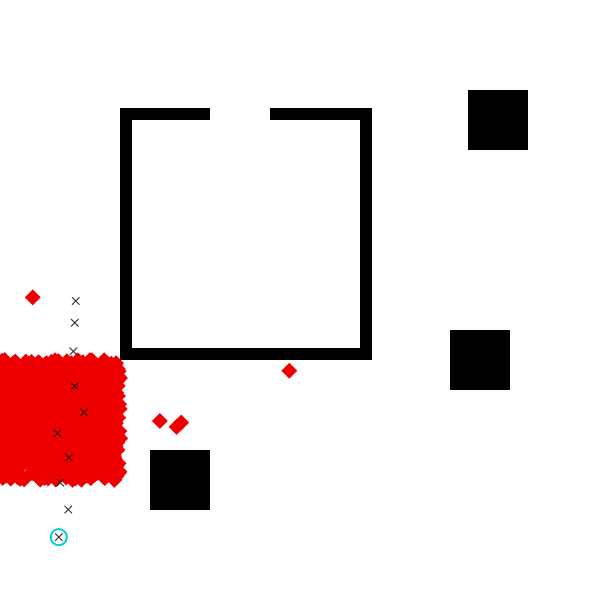

In [64]:
visualize_custom_destination_proposal(measurements, start,var_custom_dest_proposal_torch, num_samples=1000)

In [60]:
#training variational_agent_model
print(observations)
(elbo_estimate_2, traces_2, elbo_history_2) = Gen.black_box_vi!(agent_model, (scene, dt, num_ticks, planner_params), observations, variational_agent_model, (), var_update, verbose=true)

DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(:meas => DynamicChoiceMap(Dict{Any, Any}((3, :x) => 0.100412, (4, :y) => 0.237386, (7, :x) => 0.124384, (2, :y) => 0.150773, (10, :y) => 0.498338, (5, :y) => 0.277711, (4, :x) => 0.114794, (2, :x) => 0.113734, (10, :x) => 0.126227, (8, :y) => 0.414463, (1, :y) => 0.104775, (5, :x) => 0.0957668, (6, :y) => 0.31304, (9, :y) => 0.462056, (8, :x) => 0.122272, (3, :y) => 0.195499, (1, :x) => 0.0980245, (6, :x) => 0.140181, (7, :y) => 0.356242, (9, :x) => 0.124597), Dict{Any, Any}())))iter 1; est objective: -15280.654211076431
iter 2; est objective: -15709.005240253104
iter 3; est objective: -14871.807766356264
iter 4; est objective: -15549.939269558632
iter 5; est objective: -15227.937852057543
iter 6; est objective: -15426.753434720107
iter 7; est objective: -14759.036281432538
iter 8; est objective: -14754.235778759034
iter 9; est objective: -16864.15451813947
iter 10; est objective: -15426.489268919691
iter 11; est objective: -14938.25225

iter 175; est objective: -17042.472229216946
iter 176; est objective: -14612.979545668202
iter 177; est objective: -15926.498499290308
iter 178; est objective: -17118.703376237052
iter 179; est objective: -16291.027436757466
iter 180; est objective: -15822.226695158457
iter 181; est objective: -16242.731822605447
iter 182; est objective: -14284.991255660108
iter 183; est objective: -16091.713873035917
iter 184; est objective: -17083.7493419653
iter 185; est objective: -16464.494245821108
iter 186; est objective: -15917.241778010814
iter 187; est objective: -16713.15176795799
iter 188; est objective: -17238.609380784153
iter 189; est objective: -16919.233222425402
iter 190; est objective: -15200.64733714233
iter 191; est objective: -15271.165837352195
iter 192; est objective: -16183.162196911568
iter 193; est objective: -15173.024368037606
iter 194; est objective: -15964.747709639194
iter 195; est objective: -14786.399296648586
iter 196; est objective: -15605.579097825947
iter 197; est 

iter 359; est objective: -15880.653162756553
iter 360; est objective: -16190.807542029415
iter 361; est objective: -15227.645948509684
iter 362; est objective: -15256.54342540457
iter 363; est objective: -14462.402655007565
iter 364; est objective: -15894.367155252625
iter 365; est objective: -16949.848611648496
iter 366; est objective: -15519.594903286656
iter 367; est objective: -16948.26189432151
iter 368; est objective: -16233.927117632278
iter 369; est objective: -15232.353962602516
iter 370; est objective: -15686.682525378488
iter 371; est objective: -15388.052674985329
iter 372; est objective: -16872.802597301543
iter 373; est objective: -17757.955071622273
iter 374; est objective: -15328.213283370116
iter 375; est objective: -15541.111848820437
iter 376; est objective: -15235.254033445277
iter 377; est objective: -13753.574531408622
iter 378; est objective: -16562.324675390282
iter 379; est objective: -14844.483451427914
iter 380; est objective: -17594.508109011247
iter 381; es

iter 543; est objective: -14675.632510511787
iter 544; est objective: -17241.82284532585
iter 545; est objective: -14928.261332320912
iter 546; est objective: -16898.783270838376
iter 547; est objective: -16278.752134394656
iter 548; est objective: -16095.083390479613
iter 549; est objective: -15284.064813965746
iter 550; est objective: -14145.454774187776
iter 551; est objective: -16490.232152445504
iter 552; est objective: -16462.21207798938
iter 553; est objective: -14999.970603173588
iter 554; est objective: -15318.53882236005
iter 555; est objective: -17188.00506199721
iter 556; est objective: -15267.137585344028
iter 557; est objective: -16135.994714328814
iter 558; est objective: -14623.185701920162
iter 559; est objective: -15316.822628502034
iter 560; est objective: -16408.783850982265
iter 561; est objective: -15574.010060692166
iter 562; est objective: -15740.051632601422
iter 563; est objective: -16629.560195052116
iter 564; est objective: -14375.200631646745
iter 565; est 

iter 727; est objective: -15911.983843451888
iter 728; est objective: -15830.756963058284
iter 729; est objective: -16565.191720798983
iter 730; est objective: -17029.67773542151
iter 731; est objective: -16369.512925480933
iter 732; est objective: -13805.078360269377
iter 733; est objective: -13714.308228614964
iter 734; est objective: -14927.411644315322
iter 735; est objective: -17254.946142567063
iter 736; est objective: -15898.068351042044
iter 737; est objective: -16410.163479964096
iter 738; est objective: -15775.3009533106
iter 739; est objective: -14723.663044981053
iter 740; est objective: -15318.50342484046
iter 741; est objective: -14488.473768943908
iter 742; est objective: -14086.990666530068
iter 743; est objective: -16763.19688842037
iter 744; est objective: -14709.357690234147
iter 745; est objective: -14328.15946263246
iter 746; est objective: -16041.746237297944
iter 747; est objective: -15813.549212202835
iter 748; est objective: -15421.44828051087
iter 749; est obj

iter 911; est objective: -15254.268257347518
iter 912; est objective: -14838.904797657111
iter 913; est objective: -15397.677374660894
iter 914; est objective: -13504.626888233031
iter 915; est objective: -16698.048114475667
iter 916; est objective: -18211.941394954032
iter 917; est objective: -15646.97593746614
iter 918; est objective: -15015.609674845246
iter 919; est objective: -16338.616934074156
iter 920; est objective: -15920.425572237766
iter 921; est objective: -17202.012427978672
iter 922; est objective: -15046.974736689172
iter 923; est objective: -15071.35730634664
iter 924; est objective: -14023.002649606184
iter 925; est objective: -15168.42902120792
iter 926; est objective: -15746.675063634466
iter 927; est objective: -16015.870609004054
iter 928; est objective: -16496.67449163064
iter 929; est objective: -17914.11402164657
iter 930; est objective: -16477.2320097577
iter 931; est objective: -15246.1194912418
iter 932; est objective: -15663.980012755792
iter 933; est objec

(-16462.388311958613, Any[Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(:dest_x_sigma => 0.0, :speed_mu => 0.0, :dest_y_sigma => 0.0, :dest_x_mu => 0.0, :dest_y_mu => 0.0, :speed_sigma => 0.0), Dict{Symbol, Any}(:dest_x_sigma => -2.48535177346476, :speed_mu => 0.65, :dest_y_sigma => -2.4843670562671045, :dest_x_mu => 0.48664105539043123, :dest_y_mu => 0.4918475554142559, :speed_sigma => -3.1982565376654652), Type[], false, Union{Nothing, Some{Any}}[], var"##variational_agent_model#314", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:dest_y => Gen.ChoiceOrCallRecord{Float64}(0.35827068618296165, 0.2815861692922308, NaN, true), :dest_x => Gen.ChoiceOrCallRecord{Float64}(0.49328003123762115, 1.563271477483572, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), false, 1.8448576467758029, 0.0, (), nothing), Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(:dest_x_s

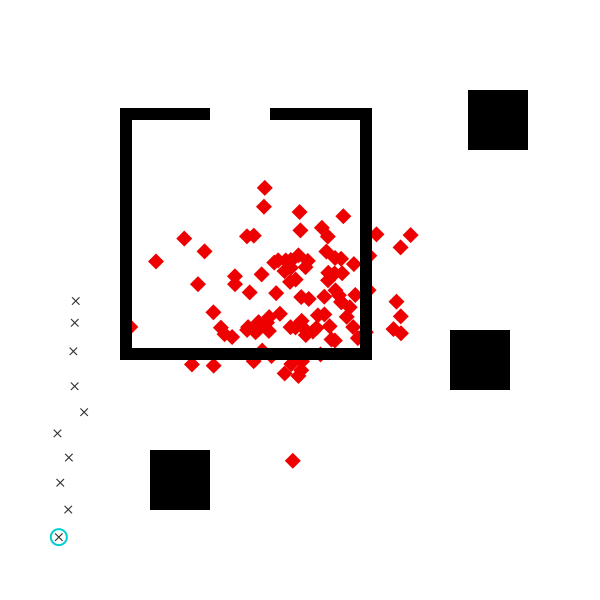

In [61]:
function visualize_variational_proposal(dest_proposal; num_samples=100)
    visualize() do 
        for i=1:num_samples
            (proposed_choices, _) = Gen.propose(dest_proposal, ())
            constraints = choicemap(proposed_choices)
            constraints[:start_x] = start.x
            constraints[:start_y] = start.y
            (trace, _) = Gen.generate(agent_model, (scene, dt, num_ticks, planner_params), constraints)
            draw_dest(scene, Point(trace[:dest_x], trace[:dest_y]))
        end
        draw_scene(scene)
        draw_start(scene, start)
        draw_measurements(scene, measurements)
    end
end;
    
visualize_variational_proposal(variational_agent_model)

# New take on variational training

In [68]:
start = Point(0.1, 0.1)
dt = 0.1
num_ticks = 10
planner_params = PlannerParams(rrt_iters=600, rrt_dt=0.05,
                               refine_iters=3500, refine_std=1.);

@gen function agent_model(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams)

    # sample the start point of the agent from the prior
    start_x ~ uniform(0, 1)
    start_y ~ uniform(0, 1)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    dest_x ~ uniform(0, 1)
    dest_y ~ uniform(0, 1)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path === nothing
    
    # sample the speed from the prior
    speed ~ uniform(0.3, 1)

    if planning_failed   
        # path planning failed; assume agent stays at start location indefinitely
        locations = fill(start, num_ticks)
    else   
        # path planning succeeded; move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.01
    for (i, point) in enumerate(locations)
        x = {:meas => (i, :x)} ~ normal(point.x, noise)
        y = {:meas => (i, :y)} ~ normal(point.y, noise)
    end

    return (planning_failed, maybe_path)
end;

In [205]:
#do we need a different neural net structure, with clear encoder and decoder parts???

x_nn_var = TorchGenerativeFunction(NeuralProposal(4), [TorchArg(true, torch.float)], 1);
y_nn_var = TorchGenerativeFunction(NeuralProposal(5), [TorchArg(true, torch.float)], 1);

shifted_measurements = [
    Point(0.5980245, 0.104775),
    Point(0.613734, 0.150773),
    Point(0.600412, 0.195499),
    Point(0.614794, 0.237386),
    Point(0.5957668, 0.277711),
    Point(0.640181, 0.31304),
    Point(0.624384, 0.356242),
    Point(0.622272, 0.414463),
    Point(0.624597, 0.462056),
    Point(0.626227, 0.498338)];

measurements = [
    Point(0.0980245, 0.104775),
    Point(0.113734, 0.150773),
    Point(0.100412, 0.195499),
    Point(0.114794, 0.237386),
    Point(0.0957668, 0.277711),
    Point(0.140181, 0.31304),
    Point(0.124384, 0.356242),
    Point(0.122272, 0.414463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

speed_sum = 0
for i in 1:length(measurements) - 1
    point1 = measurements[i]
    point2 = measurements[i+1]
    distance = sqrt((point1.x - point2.x)^2 + (point1.y - point2.y)^2)
    speed_sum += (distance / dt)
end
    
    

start = measurements[1]

#create observations choicemap
observations = Gen.choicemap()
for (i, point) in enumerate(measurements[1:length(measurements) - 2])
    observations[:meas => (i, :x)] = point.x
    observations[:meas => (i, :y)] = point.y
end

observations[:start_x] = start.x
observations[:start_y] = start.y
observations[:speed] = speed_sum / (length(measurements)) #constraining this really helps

0.4291292692995343

In [206]:
scale_coord(coord, min, max) = (coord / (max - min)) - 0.5
num_x_bins = 5
num_y_bins = 5;

#will call NNs with same vals every time
@gen function var_custom_dest_proposal_torch(measurements::Vector{Point}, scene::Scene)
    # scale inputs to be in the range [-0.5, 0.5]
    x_first = scale_coord(measurements[1].x, scene.xmin, scene.xmax)
    x_last = scale_coord(measurements[end].x, scene.xmin, scene.xmax)
    y_first = scale_coord(measurements[1].y, scene.ymin, scene.ymax)
    y_last = scale_coord(measurements[end].y, scene.ymin, scene.ymax)
    
    # sample dest_x
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    x_probs ~ x_nn_var([x_first, y_first, x_last, y_last]) #call with ~ even though not distribution as generative
    dest_x ~ piecewise_uniform(x_bounds, softmax(x_probs))
    
    # sample dest_y
    y_bounds = collect(range(scene.ymin, stop=scene.ymax, length=num_y_bins+1))
    y_probs ~ y_nn_var([x_first, y_first, x_last, y_last, dest_x]) #call with ~ even though not distribution as generative
    
    dest_y ~ piecewise_uniform(y_bounds, softmax(y_probs))
    
    return nothing
end

var_update = Gen.ParamUpdate(Gen.ADAM(0.0105, 0.9, 0.999, 1e-8), 
    x_nn_var => collect(get_params(x_nn_var)), y_nn_var => collect(get_params(y_nn_var)));

In [113]:
?Gen.ADAM

```
conf = ADAM(learning_rate, beta1, beta2, epsilon)
```

Configuration for ADAM update.


In [207]:
#training var_custom_dest_proposal
(elbo_estimate, traces, elbo_history) = Gen.black_box_vi!(agent_model, (scene, dt, num_ticks, planner_params), observations, var_custom_dest_proposal_torch, (measurements, scene), var_update, iters=200, verbose=true)

iter 1; est objective: -892.5336617220515
iter 2; est objective: -874.027987025217
iter 3; est objective: -830.6933880740642
iter 4; est objective: -734.9026234836037
iter 5; est objective: -594.4197722469833
iter 6; est objective: -380.9865317291634
iter 7; est objective: -368.5733413309715
iter 8; est objective: -214.51986286144032
iter 9; est objective: -101.41825958111427
iter 10; est objective: -73.08882072717292
iter 11; est objective: 0.3170634036433518
iter 12; est objective: -22.040591230340276
iter 13; est objective: -11.436432722105765
iter 14; est objective: 20.74200126308603
iter 15; est objective: 30.620213272886733
iter 16; est objective: 33.879186645707144
iter 17; est objective: 31.634556003423366
iter 18; est objective: 33.115819628023836
iter 19; est objective: 30.15078044544744
iter 20; est objective: 31.248556097293104
iter 21; est objective: 28.30438483399404
iter 22; est objective: 30.128414091223622
iter 23; est objective: 31.69185591841164
iter 24; est objectiv

iter 192; est objective: 28.440557426353067
iter 193; est objective: 32.90745879121811
iter 194; est objective: 33.27275368842177
iter 195; est objective: 32.13166458990004
iter 196; est objective: 29.87860508751427
iter 197; est objective: 29.198877255657834
iter 198; est objective: 31.96555394943957
iter 199; est objective: 33.396395179859944
iter 200; est objective: 31.719348359608656


(31.719348359608656, Any[Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{Point}, Scene], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##var_custom_dest_proposal_torch#355", Bool[0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:y_probs => Gen.ChoiceOrCallRecord{GenPyTorch.TorchFunctionTrace}(GenPyTorch.TorchFunctionTrace(TorchGenerativeFunction(PyObject NeuralProposal(
  (fc1): Linear(in_features=5, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=5, bias=True)
), TorchArg[TorchArg(true, PyObject torch.float32)], 1, PyObject device(type='cpu'), Dict{String, PyObject}("fc3.weight" => PyObject Parameter containing:
tensor([[-1.2676e-01, -7.7680e-03,  1.0417e-01, -1.0503e-01, -1.3360e-01,
         -2.4987e-02, -2.9952e-01, -2.7709e-01, -4.3803e-02, -4.0955e-02,
         -1.8756e-01, -1.89

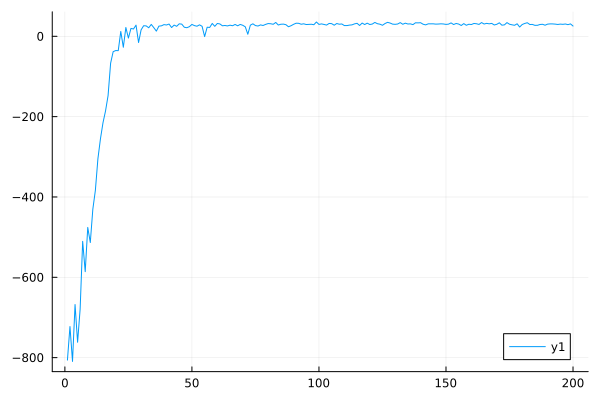

In [203]:
using Plots
plot(elbo_history)

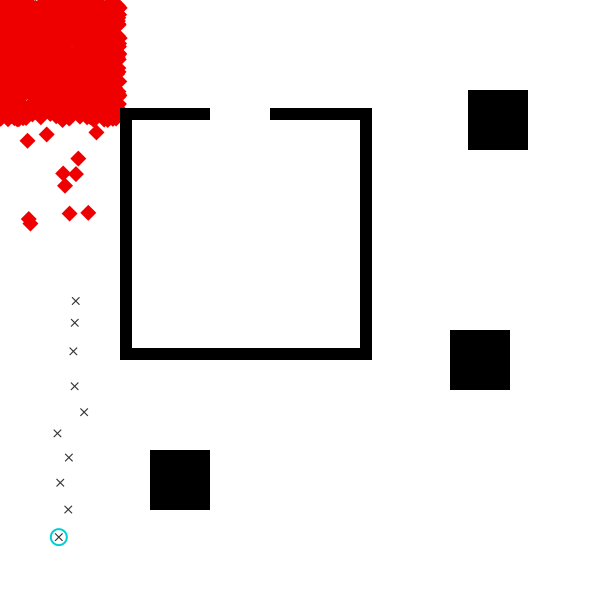

In [208]:
visualize_custom_destination_proposal(measurements, start,var_custom_dest_proposal_torch, num_samples=1000)